In [1]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
import dataloader 
from tqdm import tqdm

In [2]:
class BCIDataset(Dataset):

    def __init__(self, x, y= None):
        if y is None:
            self.y = y
        else:
            self.y = torch.FloatTensor(y)
        self.x = torch.FloatTensor(x)

    def __getitem__(self, idx):
        if self.y is None:
            return self.x[idx]
        else:
            return self.x[idx], self.y[idx]
        
    def __len__(self):
        return len(self.x)

In [3]:
import torch.nn as nn
import torch.nn.functional as F

class EEGNET(nn.Module):
    def __init__(self):
        super(EEGNET, self).__init__()

        # input [1, 2, 750]
        self.first_conv2d = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=(1, 51), stride= (1, 1), padding=(0, 25), bias= False),
            nn.BatchNorm2d(4)
        )
        # [64, 2, 750]
        self.depthwise_conv2d = nn.Sequential(
            nn.Conv2d(4, 8, kernel_size= (2, 1), stride= (1, 1), groups= 4, bias= False),
            nn.BatchNorm2d(8),
            nn.ELU(),
            nn.AvgPool2d(kernel_size= (1, 4), stride= (1, 4), padding= 0),
            nn.Dropout(0.25)
        )

        self.separable_conv2d = nn.Sequential(
            nn.Conv2d(8, 8, kernel_size= (1, 15), stride= (1, 1), padding= (0, 7), bias= False),
            nn.BatchNorm2d(8),
            nn.ELU(),
            nn.AvgPool2d(kernel_size= (1, 8), stride= (1, 8), padding= 0),
            nn.Dropout(0.25)
        )

        self.fc = nn.Sequential(
            nn.Linear(184, 2)
        )

    def forward(self, x):
        x = self.first_conv2d(x)
        x = self.depthwise_conv2d(x)
        x = self.separable_conv2d(x)
        x = x.flatten(1)
        # x = x.view(x.size()[0], -1)
        return self.fc(x)       
     

In [4]:
# hyperparameter
batch_size = 32
learning_rate = 1e-2
n_epochs = 500

In [5]:
import gc 

# load data
train_X, train_y, test_X, test_y = dataloader.read_bci_data()
print(train_X.shape, test_X.shape)

# get dataset
train_set = BCIDataset(train_X, train_y)
test_set = BCIDataset(test_X, test_y)

del train_X, train_y, test_X, test_y
gc.collect()

train_loader = DataLoader(train_set, batch_size= batch_size, shuffle= True)
test_loader = DataLoader(test_set, batch_size= batch_size, shuffle= False)

(1080, 1, 2, 750) (1080, 1, 2, 750)


In [6]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

Device: cuda:0


In [7]:
model = EEGNET().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr= learning_rate)

In [8]:
best_acc = 0
history = {"loss": [], "acc": [], "test_loss": [], "test_acc": []}

for epoch in range(n_epochs):
    
    #training
    model.train()

    batch_train_loss = []
    batch_train_acc = []

    for batch in tqdm(train_loader):

        features, labels = batch
        features = features.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        pred = model(features)
        loss = criterion(pred, labels.long())
        loss.backward()
        optimizer.step()

        acc = (pred.argmax(dim= -1) == labels).float().mean()

        batch_train_loss.append(loss.item())
        batch_train_acc.append(acc)


    train_loss = sum(batch_train_loss) / len(batch_train_loss)
    train_acc = sum(batch_train_acc) / len(batch_train_acc)
    history["loss"].append(train_loss)
    history["acc"].append(train_acc)

    # validation
    model.eval()
    
    batch_test_loss = []
    batch_test_acc = []

    with torch.no_grad():
        
        for batch in tqdm(test_loader):

            features, labels = batch
            labels = labels.to(device)
            test_pred = model(features.to(device))
            loss = criterion(test_pred, labels.long())
            acc = (test_pred.argmax(dim= -1) == labels).float().mean()

            batch_test_acc.append(acc)
            batch_test_loss.append(loss.item())

        test_loss = sum(batch_test_loss) / len(batch_test_loss)
        test_acc = sum(batch_test_acc) / len(batch_test_acc)
        history["test_loss"].append(test_loss)
        history["test_acc"].append(test_acc)
        
        print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f} [ Test | {epoch + 1:03d}/{n_epochs:03d} ] loss = {test_loss:.5f}, test_acc = {test_acc:.5f}")

    if test_acc > best_acc:
        print(f"Best model found at epoch {epoch}, saving model")
        
        torch.save(model.state_dict(), f"./best.ckpt")
        best_acc = test_acc


100%|██████████| 34/34 [00:00<00:00, 586.78it/s]


[ Train | 001/500 ] loss = 0.60672, acc = 0.67555 [ Test | 001/500 ] loss = 0.59065, test_acc = 0.69026
Best model found at epoch 0, saving model


100%|██████████| 34/34 [00:00<00:00, 558.95it/s]


[ Train | 002/500 ] loss = 0.53647, acc = 0.71936 [ Test | 002/500 ] loss = 0.54755, test_acc = 0.72763
Best model found at epoch 1, saving model


100%|██████████| 34/34 [00:00<00:00, 538.61it/s]


[ Train | 003/500 ] loss = 0.53677, acc = 0.71814 [ Test | 003/500 ] loss = 0.55157, test_acc = 0.71998


100%|██████████| 34/34 [00:00<00:00, 515.00it/s]


[ Train | 004/500 ] loss = 0.52316, acc = 0.73529 [ Test | 004/500 ] loss = 0.54574, test_acc = 0.73192
Best model found at epoch 3, saving model


100%|██████████| 34/34 [00:00<00:00, 546.59it/s]


[ Train | 005/500 ] loss = 0.51759, acc = 0.72947 [ Test | 005/500 ] loss = 0.54854, test_acc = 0.71477


100%|██████████| 34/34 [00:00<00:00, 610.85it/s]


[ Train | 006/500 ] loss = 0.51495, acc = 0.73284 [ Test | 006/500 ] loss = 0.55600, test_acc = 0.73284
Best model found at epoch 5, saving model


100%|██████████| 34/34 [00:00<00:00, 620.84it/s]


[ Train | 007/500 ] loss = 0.52098, acc = 0.74173 [ Test | 007/500 ] loss = 0.54198, test_acc = 0.72457


100%|██████████| 34/34 [00:00<00:00, 656.04it/s]


[ Train | 008/500 ] loss = 0.52306, acc = 0.74939 [ Test | 008/500 ] loss = 0.54528, test_acc = 0.72733


100%|██████████| 34/34 [00:00<00:00, 599.80it/s]


[ Train | 009/500 ] loss = 0.48520, acc = 0.77359 [ Test | 009/500 ] loss = 0.56859, test_acc = 0.71630


100%|██████████| 34/34 [00:00<00:00, 545.39it/s]


[ Train | 010/500 ] loss = 0.51542, acc = 0.74203 [ Test | 010/500 ] loss = 0.54179, test_acc = 0.71906


100%|██████████| 34/34 [00:00<00:00, 589.95it/s]


[ Train | 011/500 ] loss = 0.50469, acc = 0.74234 [ Test | 011/500 ] loss = 0.54069, test_acc = 0.72518


100%|██████████| 34/34 [00:00<00:00, 629.85it/s]


[ Train | 012/500 ] loss = 0.50277, acc = 0.74418 [ Test | 012/500 ] loss = 0.54406, test_acc = 0.71324


100%|██████████| 34/34 [00:00<00:00, 597.62it/s]


[ Train | 013/500 ] loss = 0.51605, acc = 0.73683 [ Test | 013/500 ] loss = 0.55091, test_acc = 0.72335


100%|██████████| 34/34 [00:00<00:00, 632.74it/s]


[ Train | 014/500 ] loss = 0.50903, acc = 0.72059 [ Test | 014/500 ] loss = 0.53829, test_acc = 0.72702


100%|██████████| 34/34 [00:00<00:00, 618.97it/s]


[ Train | 015/500 ] loss = 0.48991, acc = 0.74816 [ Test | 015/500 ] loss = 0.53174, test_acc = 0.72518


100%|██████████| 34/34 [00:00<00:00, 589.96it/s]


[ Train | 016/500 ] loss = 0.48866, acc = 0.76042 [ Test | 016/500 ] loss = 0.54015, test_acc = 0.73713
Best model found at epoch 15, saving model


100%|██████████| 34/34 [00:00<00:00, 636.72it/s]


[ Train | 017/500 ] loss = 0.49703, acc = 0.74908 [ Test | 017/500 ] loss = 0.54745, test_acc = 0.72059


100%|██████████| 34/34 [00:00<00:00, 619.45it/s]


[ Train | 018/500 ] loss = 0.49192, acc = 0.75031 [ Test | 018/500 ] loss = 0.53314, test_acc = 0.74540
Best model found at epoch 17, saving model


100%|██████████| 34/34 [00:00<00:00, 640.65it/s]


[ Train | 019/500 ] loss = 0.47988, acc = 0.76164 [ Test | 019/500 ] loss = 0.55865, test_acc = 0.73284


100%|██████████| 34/34 [00:00<00:00, 629.31it/s]


[ Train | 020/500 ] loss = 0.49276, acc = 0.75306 [ Test | 020/500 ] loss = 0.55482, test_acc = 0.73346


100%|██████████| 34/34 [00:00<00:00, 610.28it/s]


[ Train | 021/500 ] loss = 0.49486, acc = 0.73775 [ Test | 021/500 ] loss = 0.54376, test_acc = 0.72763


100%|██████████| 34/34 [00:00<00:00, 579.01it/s]


[ Train | 022/500 ] loss = 0.48556, acc = 0.76103 [ Test | 022/500 ] loss = 0.54863, test_acc = 0.72672


100%|██████████| 34/34 [00:00<00:00, 644.30it/s]


[ Train | 023/500 ] loss = 0.48332, acc = 0.75490 [ Test | 023/500 ] loss = 0.55827, test_acc = 0.71906


100%|██████████| 34/34 [00:00<00:00, 538.99it/s]


[ Train | 024/500 ] loss = 0.48554, acc = 0.75980 [ Test | 024/500 ] loss = 0.54373, test_acc = 0.73407


100%|██████████| 34/34 [00:00<00:00, 518.52it/s]


[ Train | 025/500 ] loss = 0.48412, acc = 0.75306 [ Test | 025/500 ] loss = 0.53398, test_acc = 0.73744


100%|██████████| 34/34 [00:00<00:00, 597.77it/s]


[ Train | 026/500 ] loss = 0.47286, acc = 0.76501 [ Test | 026/500 ] loss = 0.53413, test_acc = 0.73499


100%|██████████| 34/34 [00:00<00:00, 606.47it/s]


[ Train | 027/500 ] loss = 0.46884, acc = 0.77665 [ Test | 027/500 ] loss = 0.56797, test_acc = 0.73621


100%|██████████| 34/34 [00:00<00:00, 503.35it/s]


[ Train | 028/500 ] loss = 0.46858, acc = 0.77665 [ Test | 028/500 ] loss = 0.53584, test_acc = 0.74755
Best model found at epoch 27, saving model


100%|██████████| 34/34 [00:00<00:00, 565.91it/s]


[ Train | 029/500 ] loss = 0.47415, acc = 0.76011 [ Test | 029/500 ] loss = 0.54607, test_acc = 0.72947


100%|██████████| 34/34 [00:00<00:00, 389.77it/s]


[ Train | 030/500 ] loss = 0.48244, acc = 0.77053 [ Test | 030/500 ] loss = 0.53826, test_acc = 0.74540


100%|██████████| 34/34 [00:00<00:00, 568.78it/s]


[ Train | 031/500 ] loss = 0.47467, acc = 0.76961 [ Test | 031/500 ] loss = 0.55079, test_acc = 0.72886


100%|██████████| 34/34 [00:00<00:00, 629.41it/s]


[ Train | 032/500 ] loss = 0.47633, acc = 0.77941 [ Test | 032/500 ] loss = 0.52971, test_acc = 0.74142


100%|██████████| 34/34 [00:00<00:00, 522.95it/s]


[ Train | 033/500 ] loss = 0.45345, acc = 0.78186 [ Test | 033/500 ] loss = 0.55202, test_acc = 0.74234


100%|██████████| 34/34 [00:00<00:00, 605.02it/s]


[ Train | 034/500 ] loss = 0.44966, acc = 0.79626 [ Test | 034/500 ] loss = 0.53392, test_acc = 0.73284


100%|██████████| 34/34 [00:00<00:00, 640.46it/s]


[ Train | 035/500 ] loss = 0.45428, acc = 0.77298 [ Test | 035/500 ] loss = 0.52894, test_acc = 0.75460
Best model found at epoch 34, saving model


100%|██████████| 34/34 [00:00<00:00, 517.52it/s]


[ Train | 036/500 ] loss = 0.45317, acc = 0.78309 [ Test | 036/500 ] loss = 0.52027, test_acc = 0.76317
Best model found at epoch 35, saving model


100%|██████████| 34/34 [00:00<00:00, 511.52it/s]


[ Train | 037/500 ] loss = 0.43583, acc = 0.79657 [ Test | 037/500 ] loss = 0.48691, test_acc = 0.78186
Best model found at epoch 36, saving model


100%|██████████| 34/34 [00:00<00:00, 639.34it/s]


[ Train | 038/500 ] loss = 0.43016, acc = 0.80331 [ Test | 038/500 ] loss = 0.48952, test_acc = 0.78401
Best model found at epoch 37, saving model


100%|██████████| 34/34 [00:00<00:00, 532.63it/s]


[ Train | 039/500 ] loss = 0.39671, acc = 0.81955 [ Test | 039/500 ] loss = 0.47334, test_acc = 0.79841
Best model found at epoch 38, saving model


100%|██████████| 34/34 [00:00<00:00, 482.03it/s]


[ Train | 040/500 ] loss = 0.45645, acc = 0.79105 [ Test | 040/500 ] loss = 0.50288, test_acc = 0.77359


100%|██████████| 34/34 [00:00<00:00, 545.61it/s]


[ Train | 041/500 ] loss = 0.43132, acc = 0.79810 [ Test | 041/500 ] loss = 0.51644, test_acc = 0.77972


100%|██████████| 34/34 [00:00<00:00, 538.99it/s]


[ Train | 042/500 ] loss = 0.44416, acc = 0.80362 [ Test | 042/500 ] loss = 0.53293, test_acc = 0.77451


100%|██████████| 34/34 [00:00<00:00, 472.93it/s]


[ Train | 043/500 ] loss = 0.44516, acc = 0.79350 [ Test | 043/500 ] loss = 0.47291, test_acc = 0.78738


100%|██████████| 34/34 [00:00<00:00, 540.65it/s]


[ Train | 044/500 ] loss = 0.39302, acc = 0.83885 [ Test | 044/500 ] loss = 0.47153, test_acc = 0.79105


100%|██████████| 34/34 [00:00<00:00, 364.69it/s]


[ Train | 045/500 ] loss = 0.39808, acc = 0.81679 [ Test | 045/500 ] loss = 0.48303, test_acc = 0.78585


100%|██████████| 34/34 [00:00<00:00, 570.96it/s]


[ Train | 046/500 ] loss = 0.41435, acc = 0.80944 [ Test | 046/500 ] loss = 0.46567, test_acc = 0.79105


100%|██████████| 34/34 [00:00<00:00, 375.13it/s]


[ Train | 047/500 ] loss = 0.38486, acc = 0.81801 [ Test | 047/500 ] loss = 0.47810, test_acc = 0.79412


100%|██████████| 34/34 [00:00<00:00, 556.85it/s]


[ Train | 048/500 ] loss = 0.40624, acc = 0.80913 [ Test | 048/500 ] loss = 0.46335, test_acc = 0.79381


100%|██████████| 34/34 [00:00<00:00, 326.73it/s]


[ Train | 049/500 ] loss = 0.37963, acc = 0.82751 [ Test | 049/500 ] loss = 0.48649, test_acc = 0.78676


100%|██████████| 34/34 [00:00<00:00, 275.70it/s]


[ Train | 050/500 ] loss = 0.38288, acc = 0.83272 [ Test | 050/500 ] loss = 0.47640, test_acc = 0.79075


100%|██████████| 34/34 [00:00<00:00, 264.07it/s]


[ Train | 051/500 ] loss = 0.37729, acc = 0.82782 [ Test | 051/500 ] loss = 0.45596, test_acc = 0.80239
Best model found at epoch 50, saving model


100%|██████████| 34/34 [00:00<00:00, 366.85it/s]


[ Train | 052/500 ] loss = 0.38188, acc = 0.83364 [ Test | 052/500 ] loss = 0.47592, test_acc = 0.79197


100%|██████████| 34/34 [00:00<00:00, 430.87it/s]


[ Train | 053/500 ] loss = 0.40998, acc = 0.81250 [ Test | 053/500 ] loss = 0.47338, test_acc = 0.79320


100%|██████████| 34/34 [00:00<00:00, 309.98it/s]


[ Train | 054/500 ] loss = 0.36502, acc = 0.85263 [ Test | 054/500 ] loss = 0.46935, test_acc = 0.80331
Best model found at epoch 53, saving model


100%|██████████| 34/34 [00:00<00:00, 500.35it/s]


[ Train | 055/500 ] loss = 0.36652, acc = 0.82966 [ Test | 055/500 ] loss = 0.45577, test_acc = 0.81250
Best model found at epoch 54, saving model


100%|██████████| 34/34 [00:00<00:00, 450.13it/s]


[ Train | 056/500 ] loss = 0.37136, acc = 0.84314 [ Test | 056/500 ] loss = 0.45910, test_acc = 0.79933


100%|██████████| 34/34 [00:00<00:00, 643.48it/s]


[ Train | 057/500 ] loss = 0.39076, acc = 0.81342 [ Test | 057/500 ] loss = 0.51246, test_acc = 0.78738


100%|██████████| 34/34 [00:00<00:00, 564.97it/s]


[ Train | 058/500 ] loss = 0.37121, acc = 0.83670 [ Test | 058/500 ] loss = 0.44933, test_acc = 0.80423


100%|██████████| 34/34 [00:00<00:00, 613.80it/s]


[ Train | 059/500 ] loss = 0.35751, acc = 0.84988 [ Test | 059/500 ] loss = 0.44747, test_acc = 0.80086


100%|██████████| 34/34 [00:00<00:00, 597.84it/s]


[ Train | 060/500 ] loss = 0.34737, acc = 0.82690 [ Test | 060/500 ] loss = 0.48425, test_acc = 0.81250


100%|██████████| 34/34 [00:00<00:00, 589.95it/s]


[ Train | 061/500 ] loss = 0.36745, acc = 0.84498 [ Test | 061/500 ] loss = 0.46139, test_acc = 0.79994


100%|██████████| 34/34 [00:00<00:00, 552.99it/s]


[ Train | 062/500 ] loss = 0.34530, acc = 0.85968 [ Test | 062/500 ] loss = 0.47854, test_acc = 0.80699


100%|██████████| 34/34 [00:00<00:00, 501.19it/s]


[ Train | 063/500 ] loss = 0.38446, acc = 0.82200 [ Test | 063/500 ] loss = 0.47456, test_acc = 0.79596


100%|██████████| 34/34 [00:00<00:00, 565.79it/s]


[ Train | 064/500 ] loss = 0.37962, acc = 0.83303 [ Test | 064/500 ] loss = 0.46273, test_acc = 0.80607


100%|██████████| 34/34 [00:00<00:00, 583.89it/s]


[ Train | 065/500 ] loss = 0.34794, acc = 0.84620 [ Test | 065/500 ] loss = 0.47088, test_acc = 0.79871


100%|██████████| 34/34 [00:00<00:00, 501.81it/s]


[ Train | 066/500 ] loss = 0.35272, acc = 0.84283 [ Test | 066/500 ] loss = 0.45923, test_acc = 0.80637


100%|██████████| 34/34 [00:00<00:00, 384.46it/s]


[ Train | 067/500 ] loss = 0.36610, acc = 0.84191 [ Test | 067/500 ] loss = 0.45420, test_acc = 0.79902


100%|██████████| 34/34 [00:00<00:00, 571.38it/s]


[ Train | 068/500 ] loss = 0.32998, acc = 0.86642 [ Test | 068/500 ] loss = 0.45490, test_acc = 0.80699


100%|██████████| 34/34 [00:00<00:00, 422.87it/s]


[ Train | 069/500 ] loss = 0.33989, acc = 0.85447 [ Test | 069/500 ] loss = 0.45232, test_acc = 0.80821


100%|██████████| 34/34 [00:00<00:00, 540.61it/s]


[ Train | 070/500 ] loss = 0.34822, acc = 0.83487 [ Test | 070/500 ] loss = 0.46634, test_acc = 0.79565


100%|██████████| 34/34 [00:00<00:00, 574.37it/s]


[ Train | 071/500 ] loss = 0.34918, acc = 0.84283 [ Test | 071/500 ] loss = 0.45701, test_acc = 0.79871


100%|██████████| 34/34 [00:00<00:00, 550.44it/s]


[ Train | 072/500 ] loss = 0.36532, acc = 0.84007 [ Test | 072/500 ] loss = 0.45571, test_acc = 0.81189


100%|██████████| 34/34 [00:00<00:00, 635.53it/s]


[ Train | 073/500 ] loss = 0.32136, acc = 0.85876 [ Test | 073/500 ] loss = 0.46370, test_acc = 0.79871


100%|██████████| 34/34 [00:00<00:00, 619.80it/s]


[ Train | 074/500 ] loss = 0.33934, acc = 0.85600 [ Test | 074/500 ] loss = 0.47611, test_acc = 0.79657


100%|██████████| 34/34 [00:00<00:00, 528.26it/s]


[ Train | 075/500 ] loss = 0.34249, acc = 0.84865 [ Test | 075/500 ] loss = 0.48505, test_acc = 0.78462


100%|██████████| 34/34 [00:00<00:00, 498.13it/s]


[ Train | 076/500 ] loss = 0.35884, acc = 0.84375 [ Test | 076/500 ] loss = 0.46101, test_acc = 0.79596


100%|██████████| 34/34 [00:00<00:00, 425.66it/s]


[ Train | 077/500 ] loss = 0.33642, acc = 0.85723 [ Test | 077/500 ] loss = 0.48177, test_acc = 0.79504


100%|██████████| 34/34 [00:00<00:00, 550.78it/s]


[ Train | 078/500 ] loss = 0.32905, acc = 0.85110 [ Test | 078/500 ] loss = 0.47404, test_acc = 0.80331


100%|██████████| 34/34 [00:00<00:00, 614.65it/s]


[ Train | 079/500 ] loss = 0.32532, acc = 0.85907 [ Test | 079/500 ] loss = 0.45951, test_acc = 0.79718


100%|██████████| 34/34 [00:00<00:00, 626.10it/s]


[ Train | 080/500 ] loss = 0.34586, acc = 0.84436 [ Test | 080/500 ] loss = 0.47784, test_acc = 0.80116


100%|██████████| 34/34 [00:00<00:00, 520.10it/s]


[ Train | 081/500 ] loss = 0.34186, acc = 0.84804 [ Test | 081/500 ] loss = 0.47005, test_acc = 0.79596


100%|██████████| 34/34 [00:00<00:00, 357.03it/s]


[ Train | 082/500 ] loss = 0.35032, acc = 0.85172 [ Test | 082/500 ] loss = 0.47165, test_acc = 0.79136


100%|██████████| 34/34 [00:00<00:00, 542.92it/s]


[ Train | 083/500 ] loss = 0.32587, acc = 0.85355 [ Test | 083/500 ] loss = 0.47258, test_acc = 0.79933


100%|██████████| 34/34 [00:00<00:00, 597.95it/s]


[ Train | 084/500 ] loss = 0.30158, acc = 0.86183 [ Test | 084/500 ] loss = 0.47208, test_acc = 0.80729


100%|██████████| 34/34 [00:00<00:00, 609.62it/s]


[ Train | 085/500 ] loss = 0.31673, acc = 0.85447 [ Test | 085/500 ] loss = 0.47996, test_acc = 0.80270


100%|██████████| 34/34 [00:00<00:00, 519.18it/s]


[ Train | 086/500 ] loss = 0.32867, acc = 0.85294 [ Test | 086/500 ] loss = 0.47302, test_acc = 0.79105


100%|██████████| 34/34 [00:00<00:00, 609.10it/s]


[ Train | 087/500 ] loss = 0.30465, acc = 0.86581 [ Test | 087/500 ] loss = 0.47496, test_acc = 0.79871


100%|██████████| 34/34 [00:00<00:00, 613.07it/s]


[ Train | 088/500 ] loss = 0.33806, acc = 0.84589 [ Test | 088/500 ] loss = 0.52542, test_acc = 0.80055


100%|██████████| 34/34 [00:00<00:00, 418.85it/s]


[ Train | 089/500 ] loss = 0.37716, acc = 0.83088 [ Test | 089/500 ] loss = 0.45732, test_acc = 0.80699


100%|██████████| 34/34 [00:00<00:00, 529.96it/s]


[ Train | 090/500 ] loss = 0.29192, acc = 0.86826 [ Test | 090/500 ] loss = 0.46307, test_acc = 0.79718


100%|██████████| 34/34 [00:00<00:00, 525.19it/s]


[ Train | 091/500 ] loss = 0.33186, acc = 0.86581 [ Test | 091/500 ] loss = 0.48610, test_acc = 0.79749


100%|██████████| 34/34 [00:00<00:00, 565.44it/s]


[ Train | 092/500 ] loss = 0.32238, acc = 0.86029 [ Test | 092/500 ] loss = 0.47632, test_acc = 0.80331


100%|██████████| 34/34 [00:00<00:00, 509.37it/s]


[ Train | 093/500 ] loss = 0.31801, acc = 0.86060 [ Test | 093/500 ] loss = 0.50671, test_acc = 0.77359


100%|██████████| 34/34 [00:00<00:00, 486.40it/s]


[ Train | 094/500 ] loss = 0.33827, acc = 0.86642 [ Test | 094/500 ] loss = 0.46632, test_acc = 0.79718


100%|██████████| 34/34 [00:00<00:00, 520.95it/s]


[ Train | 095/500 ] loss = 0.33669, acc = 0.85846 [ Test | 095/500 ] loss = 0.48850, test_acc = 0.78186


100%|██████████| 34/34 [00:00<00:00, 390.60it/s]


[ Train | 096/500 ] loss = 0.31616, acc = 0.87040 [ Test | 096/500 ] loss = 0.46919, test_acc = 0.79013


100%|██████████| 34/34 [00:00<00:00, 441.87it/s]


[ Train | 097/500 ] loss = 0.33019, acc = 0.84681 [ Test | 097/500 ] loss = 0.46976, test_acc = 0.80331


100%|██████████| 34/34 [00:00<00:00, 574.26it/s]


[ Train | 098/500 ] loss = 0.30356, acc = 0.86795 [ Test | 098/500 ] loss = 0.47203, test_acc = 0.80974


100%|██████████| 34/34 [00:00<00:00, 473.74it/s]


[ Train | 099/500 ] loss = 0.31553, acc = 0.85018 [ Test | 099/500 ] loss = 0.50323, test_acc = 0.79534


100%|██████████| 34/34 [00:00<00:00, 434.60it/s]


[ Train | 100/500 ] loss = 0.32105, acc = 0.86397 [ Test | 100/500 ] loss = 0.46671, test_acc = 0.80147


100%|██████████| 34/34 [00:00<00:00, 526.30it/s]


[ Train | 101/500 ] loss = 0.32328, acc = 0.86397 [ Test | 101/500 ] loss = 0.46871, test_acc = 0.80208


100%|██████████| 34/34 [00:00<00:00, 464.57it/s]


[ Train | 102/500 ] loss = 0.32085, acc = 0.85110 [ Test | 102/500 ] loss = 0.47452, test_acc = 0.81127


100%|██████████| 34/34 [00:00<00:00, 477.93it/s]


[ Train | 103/500 ] loss = 0.31653, acc = 0.84896 [ Test | 103/500 ] loss = 0.47675, test_acc = 0.79596


100%|██████████| 34/34 [00:00<00:00, 520.77it/s]


[ Train | 104/500 ] loss = 0.29245, acc = 0.87316 [ Test | 104/500 ] loss = 0.47767, test_acc = 0.79657


100%|██████████| 34/34 [00:00<00:00, 612.05it/s]


[ Train | 105/500 ] loss = 0.30087, acc = 0.87163 [ Test | 105/500 ] loss = 0.47625, test_acc = 0.80116


100%|██████████| 34/34 [00:00<00:00, 535.27it/s]


[ Train | 106/500 ] loss = 0.29379, acc = 0.86949 [ Test | 106/500 ] loss = 0.46802, test_acc = 0.80821


100%|██████████| 34/34 [00:00<00:00, 696.49it/s]


[ Train | 107/500 ] loss = 0.29915, acc = 0.86428 [ Test | 107/500 ] loss = 0.47395, test_acc = 0.79289


100%|██████████| 34/34 [00:00<00:00, 626.79it/s]


[ Train | 108/500 ] loss = 0.31450, acc = 0.85600 [ Test | 108/500 ] loss = 0.47004, test_acc = 0.79626


100%|██████████| 34/34 [00:00<00:00, 620.01it/s]


[ Train | 109/500 ] loss = 0.30230, acc = 0.86275 [ Test | 109/500 ] loss = 0.47888, test_acc = 0.80055


100%|██████████| 34/34 [00:00<00:00, 624.09it/s]


[ Train | 110/500 ] loss = 0.31550, acc = 0.84926 [ Test | 110/500 ] loss = 0.47412, test_acc = 0.79596


100%|██████████| 34/34 [00:00<00:00, 620.49it/s]


[ Train | 111/500 ] loss = 0.31875, acc = 0.85784 [ Test | 111/500 ] loss = 0.50814, test_acc = 0.77635


100%|██████████| 34/34 [00:00<00:00, 631.93it/s]


[ Train | 112/500 ] loss = 0.32470, acc = 0.85784 [ Test | 112/500 ] loss = 0.49034, test_acc = 0.80208


100%|██████████| 34/34 [00:00<00:00, 624.75it/s]


[ Train | 113/500 ] loss = 0.28888, acc = 0.87592 [ Test | 113/500 ] loss = 0.47974, test_acc = 0.81648
Best model found at epoch 112, saving model


100%|██████████| 34/34 [00:00<00:00, 585.24it/s]


[ Train | 114/500 ] loss = 0.29474, acc = 0.87990 [ Test | 114/500 ] loss = 0.46074, test_acc = 0.80055


100%|██████████| 34/34 [00:00<00:00, 595.46it/s]


[ Train | 115/500 ] loss = 0.28933, acc = 0.86826 [ Test | 115/500 ] loss = 0.52475, test_acc = 0.79596


100%|██████████| 34/34 [00:00<00:00, 592.69it/s]


[ Train | 116/500 ] loss = 0.32416, acc = 0.85999 [ Test | 116/500 ] loss = 0.48147, test_acc = 0.80913


100%|██████████| 34/34 [00:00<00:00, 593.24it/s]


[ Train | 117/500 ] loss = 0.31605, acc = 0.86918 [ Test | 117/500 ] loss = 0.47372, test_acc = 0.79902


100%|██████████| 34/34 [00:00<00:00, 478.50it/s]


[ Train | 118/500 ] loss = 0.28689, acc = 0.87745 [ Test | 118/500 ] loss = 0.51505, test_acc = 0.79779


100%|██████████| 34/34 [00:00<00:00, 555.92it/s]


[ Train | 119/500 ] loss = 0.29739, acc = 0.87500 [ Test | 119/500 ] loss = 0.49806, test_acc = 0.80300


100%|██████████| 34/34 [00:00<00:00, 613.05it/s]


[ Train | 120/500 ] loss = 0.28859, acc = 0.87224 [ Test | 120/500 ] loss = 0.49992, test_acc = 0.80270


100%|██████████| 34/34 [00:00<00:00, 577.10it/s]


[ Train | 121/500 ] loss = 0.26315, acc = 0.90533 [ Test | 121/500 ] loss = 0.49046, test_acc = 0.80453


100%|██████████| 34/34 [00:00<00:00, 546.80it/s]


[ Train | 122/500 ] loss = 0.33239, acc = 0.85172 [ Test | 122/500 ] loss = 0.47314, test_acc = 0.81464


100%|██████████| 34/34 [00:00<00:00, 641.79it/s]


[ Train | 123/500 ] loss = 0.28907, acc = 0.88297 [ Test | 123/500 ] loss = 0.46198, test_acc = 0.82138
Best model found at epoch 122, saving model


100%|██████████| 34/34 [00:00<00:00, 575.14it/s]


[ Train | 124/500 ] loss = 0.29806, acc = 0.86397 [ Test | 124/500 ] loss = 0.46792, test_acc = 0.80668


100%|██████████| 34/34 [00:00<00:00, 611.00it/s]


[ Train | 125/500 ] loss = 0.27780, acc = 0.88542 [ Test | 125/500 ] loss = 0.46586, test_acc = 0.80637


100%|██████████| 34/34 [00:00<00:00, 523.53it/s]


[ Train | 126/500 ] loss = 0.31822, acc = 0.85815 [ Test | 126/500 ] loss = 0.48607, test_acc = 0.81005


100%|██████████| 34/34 [00:00<00:00, 601.22it/s]


[ Train | 127/500 ] loss = 0.29558, acc = 0.86581 [ Test | 127/500 ] loss = 0.50171, test_acc = 0.79688


100%|██████████| 34/34 [00:00<00:00, 581.20it/s]


[ Train | 128/500 ] loss = 0.29919, acc = 0.87806 [ Test | 128/500 ] loss = 0.47556, test_acc = 0.80545


100%|██████████| 34/34 [00:00<00:00, 597.44it/s]


[ Train | 129/500 ] loss = 0.29346, acc = 0.87868 [ Test | 129/500 ] loss = 0.46877, test_acc = 0.79718


100%|██████████| 34/34 [00:00<00:00, 639.84it/s]


[ Train | 130/500 ] loss = 0.28911, acc = 0.88419 [ Test | 130/500 ] loss = 0.47696, test_acc = 0.80147


100%|██████████| 34/34 [00:00<00:00, 586.72it/s]


[ Train | 131/500 ] loss = 0.30914, acc = 0.86612 [ Test | 131/500 ] loss = 0.51587, test_acc = 0.79289


100%|██████████| 34/34 [00:00<00:00, 623.51it/s]


[ Train | 132/500 ] loss = 0.27701, acc = 0.87990 [ Test | 132/500 ] loss = 0.47952, test_acc = 0.80086


100%|██████████| 34/34 [00:00<00:00, 580.42it/s]


[ Train | 133/500 ] loss = 0.29415, acc = 0.87653 [ Test | 133/500 ] loss = 0.48304, test_acc = 0.81771


100%|██████████| 34/34 [00:00<00:00, 504.87it/s]


[ Train | 134/500 ] loss = 0.27893, acc = 0.88082 [ Test | 134/500 ] loss = 0.50732, test_acc = 0.81281


100%|██████████| 34/34 [00:00<00:00, 530.48it/s]


[ Train | 135/500 ] loss = 0.29763, acc = 0.87592 [ Test | 135/500 ] loss = 0.49692, test_acc = 0.80116


100%|██████████| 34/34 [00:00<00:00, 615.19it/s]


[ Train | 136/500 ] loss = 0.28152, acc = 0.87500 [ Test | 136/500 ] loss = 0.50729, test_acc = 0.79473


100%|██████████| 34/34 [00:00<00:00, 627.61it/s]


[ Train | 137/500 ] loss = 0.28321, acc = 0.87714 [ Test | 137/500 ] loss = 0.52727, test_acc = 0.78799


100%|██████████| 34/34 [00:00<00:00, 589.54it/s]


[ Train | 138/500 ] loss = 0.28545, acc = 0.87868 [ Test | 138/500 ] loss = 0.49495, test_acc = 0.81556


100%|██████████| 34/34 [00:00<00:00, 612.76it/s]


[ Train | 139/500 ] loss = 0.30511, acc = 0.85999 [ Test | 139/500 ] loss = 0.46435, test_acc = 0.80362


100%|██████████| 34/34 [00:00<00:00, 620.32it/s]


[ Train | 140/500 ] loss = 0.27269, acc = 0.88756 [ Test | 140/500 ] loss = 0.48050, test_acc = 0.80974


100%|██████████| 34/34 [00:00<00:00, 476.98it/s]


[ Train | 141/500 ] loss = 0.27338, acc = 0.88572 [ Test | 141/500 ] loss = 0.48968, test_acc = 0.81036


100%|██████████| 34/34 [00:00<00:00, 644.75it/s]


[ Train | 142/500 ] loss = 0.30686, acc = 0.87071 [ Test | 142/500 ] loss = 0.49352, test_acc = 0.79749


100%|██████████| 34/34 [00:00<00:00, 596.24it/s]


[ Train | 143/500 ] loss = 0.26269, acc = 0.89246 [ Test | 143/500 ] loss = 0.49460, test_acc = 0.80178


100%|██████████| 34/34 [00:00<00:00, 640.22it/s]


[ Train | 144/500 ] loss = 0.26601, acc = 0.88542 [ Test | 144/500 ] loss = 0.49897, test_acc = 0.81250


100%|██████████| 34/34 [00:00<00:00, 650.34it/s]


[ Train | 145/500 ] loss = 0.27707, acc = 0.88664 [ Test | 145/500 ] loss = 0.49312, test_acc = 0.80300


100%|██████████| 34/34 [00:00<00:00, 605.54it/s]


[ Train | 146/500 ] loss = 0.29777, acc = 0.87531 [ Test | 146/500 ] loss = 0.51113, test_acc = 0.80545


100%|██████████| 34/34 [00:00<00:00, 576.54it/s]


[ Train | 147/500 ] loss = 0.28670, acc = 0.88511 [ Test | 147/500 ] loss = 0.49258, test_acc = 0.80147


100%|██████████| 34/34 [00:00<00:00, 571.95it/s]


[ Train | 148/500 ] loss = 0.29249, acc = 0.87439 [ Test | 148/500 ] loss = 0.47759, test_acc = 0.81740


100%|██████████| 34/34 [00:00<00:00, 628.78it/s]


[ Train | 149/500 ] loss = 0.26710, acc = 0.88143 [ Test | 149/500 ] loss = 0.49399, test_acc = 0.80147


100%|██████████| 34/34 [00:00<00:00, 604.08it/s]


[ Train | 150/500 ] loss = 0.26998, acc = 0.89246 [ Test | 150/500 ] loss = 0.48630, test_acc = 0.81403


100%|██████████| 34/34 [00:00<00:00, 518.79it/s]


[ Train | 151/500 ] loss = 0.28331, acc = 0.88756 [ Test | 151/500 ] loss = 0.46772, test_acc = 0.81526


100%|██████████| 34/34 [00:00<00:00, 510.68it/s]


[ Train | 152/500 ] loss = 0.26329, acc = 0.90074 [ Test | 152/500 ] loss = 0.47238, test_acc = 0.80944


100%|██████████| 34/34 [00:00<00:00, 630.39it/s]


[ Train | 153/500 ] loss = 0.28155, acc = 0.86887 [ Test | 153/500 ] loss = 0.49047, test_acc = 0.80055


100%|██████████| 34/34 [00:00<00:00, 646.56it/s]


[ Train | 154/500 ] loss = 0.28614, acc = 0.88940 [ Test | 154/500 ] loss = 0.47561, test_acc = 0.79902


100%|██████████| 34/34 [00:00<00:00, 621.44it/s]


[ Train | 155/500 ] loss = 0.29364, acc = 0.87653 [ Test | 155/500 ] loss = 0.50222, test_acc = 0.81097


100%|██████████| 34/34 [00:00<00:00, 602.35it/s]


[ Train | 156/500 ] loss = 0.27711, acc = 0.89185 [ Test | 156/500 ] loss = 0.49671, test_acc = 0.80913


100%|██████████| 34/34 [00:00<00:00, 615.72it/s]


[ Train | 157/500 ] loss = 0.26294, acc = 0.88327 [ Test | 157/500 ] loss = 0.49079, test_acc = 0.80331


100%|██████████| 34/34 [00:00<00:00, 579.06it/s]


[ Train | 158/500 ] loss = 0.29221, acc = 0.87623 [ Test | 158/500 ] loss = 0.47547, test_acc = 0.80300


100%|██████████| 34/34 [00:00<00:00, 612.02it/s]


[ Train | 159/500 ] loss = 0.25831, acc = 0.89062 [ Test | 159/500 ] loss = 0.46550, test_acc = 0.81832


100%|██████████| 34/34 [00:00<00:00, 559.67it/s]


[ Train | 160/500 ] loss = 0.25614, acc = 0.88327 [ Test | 160/500 ] loss = 0.46885, test_acc = 0.82782
Best model found at epoch 159, saving model


100%|██████████| 34/34 [00:00<00:00, 624.67it/s]


[ Train | 161/500 ] loss = 0.24944, acc = 0.89706 [ Test | 161/500 ] loss = 0.48853, test_acc = 0.81464


100%|██████████| 34/34 [00:00<00:00, 608.85it/s]


[ Train | 162/500 ] loss = 0.26431, acc = 0.88572 [ Test | 162/500 ] loss = 0.50343, test_acc = 0.81311


100%|██████████| 34/34 [00:00<00:00, 546.43it/s]


[ Train | 163/500 ] loss = 0.29174, acc = 0.87531 [ Test | 163/500 ] loss = 0.50866, test_acc = 0.81955


100%|██████████| 34/34 [00:00<00:00, 503.22it/s]


[ Train | 164/500 ] loss = 0.27694, acc = 0.87531 [ Test | 164/500 ] loss = 0.48497, test_acc = 0.81587


100%|██████████| 34/34 [00:00<00:00, 568.79it/s]


[ Train | 165/500 ] loss = 0.25558, acc = 0.89032 [ Test | 165/500 ] loss = 0.48480, test_acc = 0.80362


100%|██████████| 34/34 [00:00<00:00, 564.43it/s]


[ Train | 166/500 ] loss = 0.25050, acc = 0.89859 [ Test | 166/500 ] loss = 0.52277, test_acc = 0.78830


100%|██████████| 34/34 [00:00<00:00, 600.16it/s]


[ Train | 167/500 ] loss = 0.28003, acc = 0.87377 [ Test | 167/500 ] loss = 0.49497, test_acc = 0.80423


100%|██████████| 34/34 [00:00<00:00, 567.21it/s]


[ Train | 168/500 ] loss = 0.24737, acc = 0.89338 [ Test | 168/500 ] loss = 0.48496, test_acc = 0.81556


100%|██████████| 34/34 [00:00<00:00, 598.81it/s]


[ Train | 169/500 ] loss = 0.25759, acc = 0.89583 [ Test | 169/500 ] loss = 0.48734, test_acc = 0.81434


100%|██████████| 34/34 [00:00<00:00, 486.20it/s]


[ Train | 170/500 ] loss = 0.24924, acc = 0.89522 [ Test | 170/500 ] loss = 0.52009, test_acc = 0.82138


100%|██████████| 34/34 [00:00<00:00, 566.69it/s]


[ Train | 171/500 ] loss = 0.24702, acc = 0.89890 [ Test | 171/500 ] loss = 0.53052, test_acc = 0.81342


100%|██████████| 34/34 [00:00<00:00, 614.09it/s]


[ Train | 172/500 ] loss = 0.27279, acc = 0.88787 [ Test | 172/500 ] loss = 0.49557, test_acc = 0.81587


100%|██████████| 34/34 [00:00<00:00, 598.40it/s]


[ Train | 173/500 ] loss = 0.25747, acc = 0.89185 [ Test | 173/500 ] loss = 0.49070, test_acc = 0.82475


100%|██████████| 34/34 [00:00<00:00, 620.68it/s]


[ Train | 174/500 ] loss = 0.27749, acc = 0.87960 [ Test | 174/500 ] loss = 0.48175, test_acc = 0.82047


100%|██████████| 34/34 [00:00<00:00, 614.82it/s]


[ Train | 175/500 ] loss = 0.26954, acc = 0.88756 [ Test | 175/500 ] loss = 0.49703, test_acc = 0.79259


100%|██████████| 34/34 [00:00<00:00, 663.58it/s]


[ Train | 176/500 ] loss = 0.27515, acc = 0.88634 [ Test | 176/500 ] loss = 0.51903, test_acc = 0.80637


100%|██████████| 34/34 [00:00<00:00, 600.98it/s]


[ Train | 177/500 ] loss = 0.28966, acc = 0.87898 [ Test | 177/500 ] loss = 0.50696, test_acc = 0.81127


100%|██████████| 34/34 [00:00<00:00, 445.28it/s]


[ Train | 178/500 ] loss = 0.24407, acc = 0.88664 [ Test | 178/500 ] loss = 0.49789, test_acc = 0.81587


100%|██████████| 34/34 [00:00<00:00, 599.95it/s]


[ Train | 179/500 ] loss = 0.29034, acc = 0.88572 [ Test | 179/500 ] loss = 0.52345, test_acc = 0.80637


100%|██████████| 34/34 [00:00<00:00, 594.59it/s]


[ Train | 180/500 ] loss = 0.25663, acc = 0.88572 [ Test | 180/500 ] loss = 0.48120, test_acc = 0.81985


100%|██████████| 34/34 [00:00<00:00, 456.30it/s]


[ Train | 181/500 ] loss = 0.24352, acc = 0.89430 [ Test | 181/500 ] loss = 0.47337, test_acc = 0.81556


100%|██████████| 34/34 [00:00<00:00, 477.85it/s]


[ Train | 182/500 ] loss = 0.25176, acc = 0.89553 [ Test | 182/500 ] loss = 0.48770, test_acc = 0.81342


100%|██████████| 34/34 [00:00<00:00, 608.78it/s]


[ Train | 183/500 ] loss = 0.25982, acc = 0.89400 [ Test | 183/500 ] loss = 0.52488, test_acc = 0.79841


100%|██████████| 34/34 [00:00<00:00, 598.99it/s]


[ Train | 184/500 ] loss = 0.25202, acc = 0.88848 [ Test | 184/500 ] loss = 0.47979, test_acc = 0.81495


100%|██████████| 34/34 [00:00<00:00, 623.10it/s]


[ Train | 185/500 ] loss = 0.25429, acc = 0.88848 [ Test | 185/500 ] loss = 0.50975, test_acc = 0.82047


100%|██████████| 34/34 [00:00<00:00, 639.58it/s]


[ Train | 186/500 ] loss = 0.22901, acc = 0.90043 [ Test | 186/500 ] loss = 0.51231, test_acc = 0.81648


100%|██████████| 34/34 [00:00<00:00, 587.29it/s]


[ Train | 187/500 ] loss = 0.24593, acc = 0.89583 [ Test | 187/500 ] loss = 0.53737, test_acc = 0.80699


100%|██████████| 34/34 [00:00<00:00, 500.61it/s]


[ Train | 188/500 ] loss = 0.24109, acc = 0.89246 [ Test | 188/500 ] loss = 0.50299, test_acc = 0.80147


100%|██████████| 34/34 [00:00<00:00, 564.76it/s]


[ Train | 189/500 ] loss = 0.22180, acc = 0.90411 [ Test | 189/500 ] loss = 0.49540, test_acc = 0.81556


100%|██████████| 34/34 [00:00<00:00, 600.69it/s]


[ Train | 190/500 ] loss = 0.25940, acc = 0.89430 [ Test | 190/500 ] loss = 0.52865, test_acc = 0.78799


100%|██████████| 34/34 [00:00<00:00, 648.27it/s]


[ Train | 191/500 ] loss = 0.24950, acc = 0.90043 [ Test | 191/500 ] loss = 0.50951, test_acc = 0.81097


100%|██████████| 34/34 [00:00<00:00, 613.92it/s]


[ Train | 192/500 ] loss = 0.25872, acc = 0.89001 [ Test | 192/500 ] loss = 0.51235, test_acc = 0.81771


100%|██████████| 34/34 [00:00<00:00, 616.99it/s]


[ Train | 193/500 ] loss = 0.24815, acc = 0.90074 [ Test | 193/500 ] loss = 0.52257, test_acc = 0.81005


100%|██████████| 34/34 [00:00<00:00, 586.37it/s]


[ Train | 194/500 ] loss = 0.24807, acc = 0.91207 [ Test | 194/500 ] loss = 0.50593, test_acc = 0.81403


100%|██████████| 34/34 [00:00<00:00, 606.94it/s]


[ Train | 195/500 ] loss = 0.26731, acc = 0.89216 [ Test | 195/500 ] loss = 0.51383, test_acc = 0.82047


100%|██████████| 34/34 [00:00<00:00, 612.39it/s]


[ Train | 196/500 ] loss = 0.26191, acc = 0.88971 [ Test | 196/500 ] loss = 0.49542, test_acc = 0.81526


100%|██████████| 34/34 [00:00<00:00, 580.40it/s]


[ Train | 197/500 ] loss = 0.24113, acc = 0.90349 [ Test | 197/500 ] loss = 0.52805, test_acc = 0.81127


100%|██████████| 34/34 [00:00<00:00, 593.04it/s]


[ Train | 198/500 ] loss = 0.25216, acc = 0.88695 [ Test | 198/500 ] loss = 0.51318, test_acc = 0.81556


100%|██████████| 34/34 [00:00<00:00, 582.84it/s]


[ Train | 199/500 ] loss = 0.23494, acc = 0.89246 [ Test | 199/500 ] loss = 0.52196, test_acc = 0.81740


100%|██████████| 34/34 [00:00<00:00, 608.49it/s]


[ Train | 200/500 ] loss = 0.23848, acc = 0.89369 [ Test | 200/500 ] loss = 0.59109, test_acc = 0.80270


100%|██████████| 34/34 [00:00<00:00, 611.44it/s]


[ Train | 201/500 ] loss = 0.22676, acc = 0.90502 [ Test | 201/500 ] loss = 0.55513, test_acc = 0.80913


100%|██████████| 34/34 [00:00<00:00, 508.50it/s]


[ Train | 202/500 ] loss = 0.27935, acc = 0.89522 [ Test | 202/500 ] loss = 0.52276, test_acc = 0.81740


100%|██████████| 34/34 [00:00<00:00, 602.41it/s]


[ Train | 203/500 ] loss = 0.25252, acc = 0.89491 [ Test | 203/500 ] loss = 0.52971, test_acc = 0.80453


100%|██████████| 34/34 [00:00<00:00, 599.67it/s]


[ Train | 204/500 ] loss = 0.25877, acc = 0.88358 [ Test | 204/500 ] loss = 0.50916, test_acc = 0.81036


100%|██████████| 34/34 [00:00<00:00, 585.47it/s]


[ Train | 205/500 ] loss = 0.23646, acc = 0.90227 [ Test | 205/500 ] loss = 0.55323, test_acc = 0.77819


100%|██████████| 34/34 [00:00<00:00, 596.24it/s]


[ Train | 206/500 ] loss = 0.26819, acc = 0.89032 [ Test | 206/500 ] loss = 0.51573, test_acc = 0.80116


100%|██████████| 34/34 [00:00<00:00, 582.92it/s]


[ Train | 207/500 ] loss = 0.22512, acc = 0.90625 [ Test | 207/500 ] loss = 0.52427, test_acc = 0.81219


100%|██████████| 34/34 [00:00<00:00, 530.13it/s]


[ Train | 208/500 ] loss = 0.26324, acc = 0.88297 [ Test | 208/500 ] loss = 0.52927, test_acc = 0.81464


100%|██████████| 34/34 [00:00<00:00, 581.47it/s]


[ Train | 209/500 ] loss = 0.26555, acc = 0.88940 [ Test | 209/500 ] loss = 0.51989, test_acc = 0.81587


100%|██████████| 34/34 [00:00<00:00, 585.46it/s]


[ Train | 210/500 ] loss = 0.24160, acc = 0.89737 [ Test | 210/500 ] loss = 0.52287, test_acc = 0.81832


100%|██████████| 34/34 [00:00<00:00, 600.75it/s]


[ Train | 211/500 ] loss = 0.24016, acc = 0.89553 [ Test | 211/500 ] loss = 0.52295, test_acc = 0.81219


100%|██████████| 34/34 [00:00<00:00, 451.44it/s]


[ Train | 212/500 ] loss = 0.24703, acc = 0.90165 [ Test | 212/500 ] loss = 0.52806, test_acc = 0.81556


100%|██████████| 34/34 [00:00<00:00, 530.95it/s]


[ Train | 213/500 ] loss = 0.25239, acc = 0.89982 [ Test | 213/500 ] loss = 0.50605, test_acc = 0.81311


100%|██████████| 34/34 [00:00<00:00, 592.85it/s]


[ Train | 214/500 ] loss = 0.22303, acc = 0.90993 [ Test | 214/500 ] loss = 0.53133, test_acc = 0.80760


100%|██████████| 34/34 [00:00<00:00, 577.26it/s]


[ Train | 215/500 ] loss = 0.20883, acc = 0.91575 [ Test | 215/500 ] loss = 0.53806, test_acc = 0.81219


100%|██████████| 34/34 [00:00<00:00, 641.75it/s]


[ Train | 216/500 ] loss = 0.25466, acc = 0.89828 [ Test | 216/500 ] loss = 0.54132, test_acc = 0.80116


100%|██████████| 34/34 [00:00<00:00, 569.74it/s]


[ Train | 217/500 ] loss = 0.25158, acc = 0.89675 [ Test | 217/500 ] loss = 0.52523, test_acc = 0.81495


100%|██████████| 34/34 [00:00<00:00, 587.50it/s]


[ Train | 218/500 ] loss = 0.25362, acc = 0.90165 [ Test | 218/500 ] loss = 0.52368, test_acc = 0.81556


100%|██████████| 34/34 [00:00<00:00, 497.18it/s]


[ Train | 219/500 ] loss = 0.25877, acc = 0.89982 [ Test | 219/500 ] loss = 0.54073, test_acc = 0.81005


100%|██████████| 34/34 [00:00<00:00, 587.63it/s]


[ Train | 220/500 ] loss = 0.26520, acc = 0.88082 [ Test | 220/500 ] loss = 0.52181, test_acc = 0.80086


100%|██████████| 34/34 [00:00<00:00, 593.45it/s]


[ Train | 221/500 ] loss = 0.27233, acc = 0.89001 [ Test | 221/500 ] loss = 0.50153, test_acc = 0.80760


100%|██████████| 34/34 [00:00<00:00, 595.58it/s]


[ Train | 222/500 ] loss = 0.23094, acc = 0.90502 [ Test | 222/500 ] loss = 0.52367, test_acc = 0.79626


100%|██████████| 34/34 [00:00<00:00, 608.45it/s]


[ Train | 223/500 ] loss = 0.25191, acc = 0.89001 [ Test | 223/500 ] loss = 0.49521, test_acc = 0.81403


100%|██████████| 34/34 [00:00<00:00, 585.26it/s]


[ Train | 224/500 ] loss = 0.21976, acc = 0.91452 [ Test | 224/500 ] loss = 0.50413, test_acc = 0.82322


100%|██████████| 34/34 [00:00<00:00, 603.03it/s]


[ Train | 225/500 ] loss = 0.23927, acc = 0.90257 [ Test | 225/500 ] loss = 0.54097, test_acc = 0.79320


100%|██████████| 34/34 [00:00<00:00, 609.35it/s]


[ Train | 226/500 ] loss = 0.26323, acc = 0.89062 [ Test | 226/500 ] loss = 0.54359, test_acc = 0.81127


100%|██████████| 34/34 [00:00<00:00, 639.36it/s]


[ Train | 227/500 ] loss = 0.22397, acc = 0.90380 [ Test | 227/500 ] loss = 0.53475, test_acc = 0.81679


100%|██████████| 34/34 [00:00<00:00, 589.47it/s]


[ Train | 228/500 ] loss = 0.22161, acc = 0.91330 [ Test | 228/500 ] loss = 0.51481, test_acc = 0.81648


100%|██████████| 34/34 [00:00<00:00, 612.09it/s]


[ Train | 229/500 ] loss = 0.26823, acc = 0.89400 [ Test | 229/500 ] loss = 0.55152, test_acc = 0.78646


100%|██████████| 34/34 [00:00<00:00, 447.23it/s]


[ Train | 230/500 ] loss = 0.21738, acc = 0.91023 [ Test | 230/500 ] loss = 0.51792, test_acc = 0.81464


100%|██████████| 34/34 [00:00<00:00, 628.47it/s]


[ Train | 231/500 ] loss = 0.23861, acc = 0.90135 [ Test | 231/500 ] loss = 0.54705, test_acc = 0.80668


100%|██████████| 34/34 [00:00<00:00, 613.62it/s]


[ Train | 232/500 ] loss = 0.20949, acc = 0.90748 [ Test | 232/500 ] loss = 0.52721, test_acc = 0.82200


100%|██████████| 34/34 [00:00<00:00, 601.84it/s]


[ Train | 233/500 ] loss = 0.22121, acc = 0.90870 [ Test | 233/500 ] loss = 0.60025, test_acc = 0.80392


100%|██████████| 34/34 [00:00<00:00, 665.37it/s]


[ Train | 234/500 ] loss = 0.24771, acc = 0.89093 [ Test | 234/500 ] loss = 0.52855, test_acc = 0.81924


100%|██████████| 34/34 [00:00<00:00, 574.63it/s]


[ Train | 235/500 ] loss = 0.25986, acc = 0.88940 [ Test | 235/500 ] loss = 0.52579, test_acc = 0.81679


100%|██████████| 34/34 [00:00<00:00, 604.50it/s]


[ Train | 236/500 ] loss = 0.22910, acc = 0.89828 [ Test | 236/500 ] loss = 0.55208, test_acc = 0.80760


100%|██████████| 34/34 [00:00<00:00, 618.00it/s]


[ Train | 237/500 ] loss = 0.23723, acc = 0.89308 [ Test | 237/500 ] loss = 0.53415, test_acc = 0.81219


100%|██████████| 34/34 [00:00<00:00, 644.30it/s]


[ Train | 238/500 ] loss = 0.26749, acc = 0.89553 [ Test | 238/500 ] loss = 0.52766, test_acc = 0.79871


100%|██████████| 34/34 [00:00<00:00, 525.92it/s]


[ Train | 239/500 ] loss = 0.22732, acc = 0.89951 [ Test | 239/500 ] loss = 0.55121, test_acc = 0.80637


100%|██████████| 34/34 [00:00<00:00, 567.48it/s]


[ Train | 240/500 ] loss = 0.22006, acc = 0.91299 [ Test | 240/500 ] loss = 0.52501, test_acc = 0.81648


100%|██████████| 34/34 [00:00<00:00, 604.94it/s]


[ Train | 241/500 ] loss = 0.23025, acc = 0.89859 [ Test | 241/500 ] loss = 0.55057, test_acc = 0.81097


100%|██████████| 34/34 [00:00<00:00, 514.61it/s]


[ Train | 242/500 ] loss = 0.23569, acc = 0.90227 [ Test | 242/500 ] loss = 0.53305, test_acc = 0.80913


100%|██████████| 34/34 [00:00<00:00, 577.40it/s]


[ Train | 243/500 ] loss = 0.23625, acc = 0.90135 [ Test | 243/500 ] loss = 0.52046, test_acc = 0.82475


100%|██████████| 34/34 [00:00<00:00, 631.11it/s]


[ Train | 244/500 ] loss = 0.24994, acc = 0.90472 [ Test | 244/500 ] loss = 0.52933, test_acc = 0.81556


100%|██████████| 34/34 [00:00<00:00, 600.10it/s]


[ Train | 245/500 ] loss = 0.22008, acc = 0.90227 [ Test | 245/500 ] loss = 0.52848, test_acc = 0.82506


100%|██████████| 34/34 [00:00<00:00, 615.29it/s]


[ Train | 246/500 ] loss = 0.23395, acc = 0.91268 [ Test | 246/500 ] loss = 0.56410, test_acc = 0.79504


100%|██████████| 34/34 [00:00<00:00, 576.52it/s]


[ Train | 247/500 ] loss = 0.23006, acc = 0.90748 [ Test | 247/500 ] loss = 0.54967, test_acc = 0.80913


100%|██████████| 34/34 [00:00<00:00, 608.47it/s]


[ Train | 248/500 ] loss = 0.26120, acc = 0.89583 [ Test | 248/500 ] loss = 0.51763, test_acc = 0.82138


100%|██████████| 34/34 [00:00<00:00, 576.39it/s]


[ Train | 249/500 ] loss = 0.21773, acc = 0.90564 [ Test | 249/500 ] loss = 0.51930, test_acc = 0.79810


100%|██████████| 34/34 [00:00<00:00, 617.07it/s]


[ Train | 250/500 ] loss = 0.23476, acc = 0.88909 [ Test | 250/500 ] loss = 0.52789, test_acc = 0.80331


100%|██████████| 34/34 [00:00<00:00, 631.16it/s]


[ Train | 251/500 ] loss = 0.26223, acc = 0.89982 [ Test | 251/500 ] loss = 0.51547, test_acc = 0.81189


100%|██████████| 34/34 [00:00<00:00, 518.88it/s]


[ Train | 252/500 ] loss = 0.22320, acc = 0.90748 [ Test | 252/500 ] loss = 0.52467, test_acc = 0.81955


100%|██████████| 34/34 [00:00<00:00, 621.52it/s]


[ Train | 253/500 ] loss = 0.26876, acc = 0.89154 [ Test | 253/500 ] loss = 0.49140, test_acc = 0.81648


100%|██████████| 34/34 [00:00<00:00, 548.77it/s]


[ Train | 254/500 ] loss = 0.24709, acc = 0.89737 [ Test | 254/500 ] loss = 0.50616, test_acc = 0.81556


100%|██████████| 34/34 [00:00<00:00, 548.90it/s]


[ Train | 255/500 ] loss = 0.21967, acc = 0.90257 [ Test | 255/500 ] loss = 0.54050, test_acc = 0.80545


100%|██████████| 34/34 [00:00<00:00, 451.38it/s]


[ Train | 256/500 ] loss = 0.23812, acc = 0.90043 [ Test | 256/500 ] loss = 0.53172, test_acc = 0.80913


100%|██████████| 34/34 [00:00<00:00, 460.60it/s]


[ Train | 257/500 ] loss = 0.26075, acc = 0.89216 [ Test | 257/500 ] loss = 0.53483, test_acc = 0.79810


100%|██████████| 34/34 [00:00<00:00, 562.67it/s]


[ Train | 258/500 ] loss = 0.23566, acc = 0.89982 [ Test | 258/500 ] loss = 0.52843, test_acc = 0.80208


100%|██████████| 34/34 [00:00<00:00, 635.64it/s]


[ Train | 259/500 ] loss = 0.22798, acc = 0.89798 [ Test | 259/500 ] loss = 0.53146, test_acc = 0.79718


100%|██████████| 34/34 [00:00<00:00, 613.41it/s]


[ Train | 260/500 ] loss = 0.27432, acc = 0.88725 [ Test | 260/500 ] loss = 0.50837, test_acc = 0.82230


100%|██████████| 34/34 [00:00<00:00, 577.03it/s]


[ Train | 261/500 ] loss = 0.23938, acc = 0.89859 [ Test | 261/500 ] loss = 0.52917, test_acc = 0.82047


100%|██████████| 34/34 [00:00<00:00, 678.58it/s]


[ Train | 262/500 ] loss = 0.21509, acc = 0.90564 [ Test | 262/500 ] loss = 0.52038, test_acc = 0.81495


100%|██████████| 34/34 [00:00<00:00, 645.60it/s]


[ Train | 263/500 ] loss = 0.21412, acc = 0.91697 [ Test | 263/500 ] loss = 0.55100, test_acc = 0.80086


100%|██████████| 34/34 [00:00<00:00, 632.45it/s]


[ Train | 264/500 ] loss = 0.22302, acc = 0.91605 [ Test | 264/500 ] loss = 0.51778, test_acc = 0.81189


100%|██████████| 34/34 [00:00<00:00, 661.48it/s]


[ Train | 265/500 ] loss = 0.23265, acc = 0.90135 [ Test | 265/500 ] loss = 0.59848, test_acc = 0.80086


100%|██████████| 34/34 [00:00<00:00, 663.41it/s]


[ Train | 266/500 ] loss = 0.22776, acc = 0.90502 [ Test | 266/500 ] loss = 0.58226, test_acc = 0.79841


100%|██████████| 34/34 [00:00<00:00, 574.44it/s]


[ Train | 267/500 ] loss = 0.23048, acc = 0.90656 [ Test | 267/500 ] loss = 0.53478, test_acc = 0.80208


100%|██████████| 34/34 [00:00<00:00, 645.34it/s]


[ Train | 268/500 ] loss = 0.21917, acc = 0.90901 [ Test | 268/500 ] loss = 0.50726, test_acc = 0.81495


100%|██████████| 34/34 [00:00<00:00, 640.35it/s]


[ Train | 269/500 ] loss = 0.21311, acc = 0.90380 [ Test | 269/500 ] loss = 0.52736, test_acc = 0.81005


100%|██████████| 34/34 [00:00<00:00, 646.83it/s]


[ Train | 270/500 ] loss = 0.25925, acc = 0.88113 [ Test | 270/500 ] loss = 0.54900, test_acc = 0.81005


100%|██████████| 34/34 [00:00<00:00, 638.73it/s]


[ Train | 271/500 ] loss = 0.20741, acc = 0.91023 [ Test | 271/500 ] loss = 0.55527, test_acc = 0.81587


100%|██████████| 34/34 [00:00<00:00, 616.96it/s]


[ Train | 272/500 ] loss = 0.21651, acc = 0.90227 [ Test | 272/500 ] loss = 0.52789, test_acc = 0.81219


100%|██████████| 34/34 [00:00<00:00, 562.21it/s]


[ Train | 273/500 ] loss = 0.24663, acc = 0.89553 [ Test | 273/500 ] loss = 0.52827, test_acc = 0.81587


100%|██████████| 34/34 [00:00<00:00, 629.88it/s]


[ Train | 274/500 ] loss = 0.21930, acc = 0.91146 [ Test | 274/500 ] loss = 0.55406, test_acc = 0.81097


100%|██████████| 34/34 [00:00<00:00, 637.82it/s]


[ Train | 275/500 ] loss = 0.23687, acc = 0.90196 [ Test | 275/500 ] loss = 0.54862, test_acc = 0.81740


100%|██████████| 34/34 [00:00<00:00, 615.30it/s]


[ Train | 276/500 ] loss = 0.21665, acc = 0.90349 [ Test | 276/500 ] loss = 0.55620, test_acc = 0.81495


100%|██████████| 34/34 [00:00<00:00, 643.04it/s]


[ Train | 277/500 ] loss = 0.20214, acc = 0.91207 [ Test | 277/500 ] loss = 0.55172, test_acc = 0.81281


100%|██████████| 34/34 [00:00<00:00, 663.25it/s]


[ Train | 278/500 ] loss = 0.23395, acc = 0.89982 [ Test | 278/500 ] loss = 0.55046, test_acc = 0.81097


100%|██████████| 34/34 [00:00<00:00, 657.99it/s]


[ Train | 279/500 ] loss = 0.21515, acc = 0.90257 [ Test | 279/500 ] loss = 0.57422, test_acc = 0.81556


100%|██████████| 34/34 [00:00<00:00, 599.06it/s]


[ Train | 280/500 ] loss = 0.22214, acc = 0.89798 [ Test | 280/500 ] loss = 0.54457, test_acc = 0.80760


100%|██████████| 34/34 [00:00<00:00, 668.47it/s]


[ Train | 281/500 ] loss = 0.21336, acc = 0.91605 [ Test | 281/500 ] loss = 0.53682, test_acc = 0.82138


100%|██████████| 34/34 [00:00<00:00, 661.80it/s]


[ Train | 282/500 ] loss = 0.24584, acc = 0.89890 [ Test | 282/500 ] loss = 0.54760, test_acc = 0.81495


100%|██████████| 34/34 [00:00<00:00, 661.61it/s]


[ Train | 283/500 ] loss = 0.22266, acc = 0.90809 [ Test | 283/500 ] loss = 0.53095, test_acc = 0.80453


100%|██████████| 34/34 [00:00<00:00, 642.57it/s]


[ Train | 284/500 ] loss = 0.20960, acc = 0.91850 [ Test | 284/500 ] loss = 0.57162, test_acc = 0.79442


100%|██████████| 34/34 [00:00<00:00, 617.92it/s]


[ Train | 285/500 ] loss = 0.23811, acc = 0.90870 [ Test | 285/500 ] loss = 0.52102, test_acc = 0.81464


100%|██████████| 34/34 [00:00<00:00, 653.41it/s]


[ Train | 286/500 ] loss = 0.23231, acc = 0.91207 [ Test | 286/500 ] loss = 0.58100, test_acc = 0.79412


100%|██████████| 34/34 [00:00<00:00, 652.96it/s]


[ Train | 287/500 ] loss = 0.24102, acc = 0.90656 [ Test | 287/500 ] loss = 0.55492, test_acc = 0.81189


100%|██████████| 34/34 [00:00<00:00, 652.90it/s]


[ Train | 288/500 ] loss = 0.22006, acc = 0.90901 [ Test | 288/500 ] loss = 0.55951, test_acc = 0.80086


100%|██████████| 34/34 [00:00<00:00, 646.78it/s]


[ Train | 289/500 ] loss = 0.23886, acc = 0.90135 [ Test | 289/500 ] loss = 0.52800, test_acc = 0.81005


100%|██████████| 34/34 [00:00<00:00, 658.31it/s]


[ Train | 290/500 ] loss = 0.21290, acc = 0.90993 [ Test | 290/500 ] loss = 0.55278, test_acc = 0.81403


100%|██████████| 34/34 [00:00<00:00, 653.32it/s]


[ Train | 291/500 ] loss = 0.22057, acc = 0.91054 [ Test | 291/500 ] loss = 0.52949, test_acc = 0.81464


100%|██████████| 34/34 [00:00<00:00, 663.24it/s]


[ Train | 292/500 ] loss = 0.19980, acc = 0.91452 [ Test | 292/500 ] loss = 0.52610, test_acc = 0.81832


100%|██████████| 34/34 [00:00<00:00, 583.46it/s]


[ Train | 293/500 ] loss = 0.20525, acc = 0.91146 [ Test | 293/500 ] loss = 0.58494, test_acc = 0.79718


100%|██████████| 34/34 [00:00<00:00, 641.91it/s]


[ Train | 294/500 ] loss = 0.19925, acc = 0.91850 [ Test | 294/500 ] loss = 0.53545, test_acc = 0.81097


100%|██████████| 34/34 [00:00<00:00, 360.84it/s]


[ Train | 295/500 ] loss = 0.23240, acc = 0.90196 [ Test | 295/500 ] loss = 0.54948, test_acc = 0.81311


100%|██████████| 34/34 [00:00<00:00, 657.04it/s]


[ Train | 296/500 ] loss = 0.20761, acc = 0.91115 [ Test | 296/500 ] loss = 0.53231, test_acc = 0.80882


100%|██████████| 34/34 [00:00<00:00, 639.72it/s]


[ Train | 297/500 ] loss = 0.22812, acc = 0.89890 [ Test | 297/500 ] loss = 0.53257, test_acc = 0.79902


100%|██████████| 34/34 [00:00<00:00, 590.06it/s]


[ Train | 298/500 ] loss = 0.22736, acc = 0.90901 [ Test | 298/500 ] loss = 0.52465, test_acc = 0.81924


100%|██████████| 34/34 [00:00<00:00, 622.74it/s]


[ Train | 299/500 ] loss = 0.21423, acc = 0.90625 [ Test | 299/500 ] loss = 0.54517, test_acc = 0.81189


100%|██████████| 34/34 [00:00<00:00, 656.36it/s]


[ Train | 300/500 ] loss = 0.23666, acc = 0.90288 [ Test | 300/500 ] loss = 0.57337, test_acc = 0.81127


100%|██████████| 34/34 [00:00<00:00, 651.37it/s]


[ Train | 301/500 ] loss = 0.20267, acc = 0.91912 [ Test | 301/500 ] loss = 0.53850, test_acc = 0.82016


100%|██████████| 34/34 [00:00<00:00, 642.73it/s]


[ Train | 302/500 ] loss = 0.21737, acc = 0.90319 [ Test | 302/500 ] loss = 0.54713, test_acc = 0.81311


100%|██████████| 34/34 [00:00<00:00, 534.23it/s]


[ Train | 303/500 ] loss = 0.21519, acc = 0.91085 [ Test | 303/500 ] loss = 0.55505, test_acc = 0.80362


100%|██████████| 34/34 [00:00<00:00, 613.48it/s]


[ Train | 304/500 ] loss = 0.22949, acc = 0.90074 [ Test | 304/500 ] loss = 0.52280, test_acc = 0.80545


100%|██████████| 34/34 [00:00<00:00, 652.62it/s]


[ Train | 305/500 ] loss = 0.20772, acc = 0.90839 [ Test | 305/500 ] loss = 0.53866, test_acc = 0.81311


100%|██████████| 34/34 [00:00<00:00, 631.40it/s]


[ Train | 306/500 ] loss = 0.22828, acc = 0.91360 [ Test | 306/500 ] loss = 0.56910, test_acc = 0.79197


100%|██████████| 34/34 [00:00<00:00, 634.18it/s]


[ Train | 307/500 ] loss = 0.22004, acc = 0.90748 [ Test | 307/500 ] loss = 0.56808, test_acc = 0.79749


100%|██████████| 34/34 [00:00<00:00, 646.73it/s]


[ Train | 308/500 ] loss = 0.21541, acc = 0.92433 [ Test | 308/500 ] loss = 0.56251, test_acc = 0.81373


100%|██████████| 34/34 [00:00<00:00, 650.94it/s]


[ Train | 309/500 ] loss = 0.19109, acc = 0.92004 [ Test | 309/500 ] loss = 0.54184, test_acc = 0.81281


100%|██████████| 34/34 [00:00<00:00, 682.13it/s]


[ Train | 310/500 ] loss = 0.21099, acc = 0.91881 [ Test | 310/500 ] loss = 0.56661, test_acc = 0.81464


100%|██████████| 34/34 [00:00<00:00, 612.72it/s]


[ Train | 311/500 ] loss = 0.24371, acc = 0.89951 [ Test | 311/500 ] loss = 0.57502, test_acc = 0.81097


100%|██████████| 34/34 [00:00<00:00, 636.73it/s]


[ Train | 312/500 ] loss = 0.22759, acc = 0.91452 [ Test | 312/500 ] loss = 0.55595, test_acc = 0.80208


100%|██████████| 34/34 [00:00<00:00, 582.81it/s]


[ Train | 313/500 ] loss = 0.19773, acc = 0.91299 [ Test | 313/500 ] loss = 0.59704, test_acc = 0.82690


100%|██████████| 34/34 [00:00<00:00, 646.91it/s]


[ Train | 314/500 ] loss = 0.21637, acc = 0.91054 [ Test | 314/500 ] loss = 0.55098, test_acc = 0.81771


100%|██████████| 34/34 [00:00<00:00, 630.28it/s]


[ Train | 315/500 ] loss = 0.22244, acc = 0.90809 [ Test | 315/500 ] loss = 0.55847, test_acc = 0.80086


100%|██████████| 34/34 [00:00<00:00, 613.59it/s]


[ Train | 316/500 ] loss = 0.24597, acc = 0.89614 [ Test | 316/500 ] loss = 0.54098, test_acc = 0.81587


100%|██████████| 34/34 [00:00<00:00, 636.43it/s]


[ Train | 317/500 ] loss = 0.21862, acc = 0.91176 [ Test | 317/500 ] loss = 0.58461, test_acc = 0.80178


100%|██████████| 34/34 [00:00<00:00, 578.39it/s]


[ Train | 318/500 ] loss = 0.19709, acc = 0.91973 [ Test | 318/500 ] loss = 0.54856, test_acc = 0.81036


100%|██████████| 34/34 [00:00<00:00, 546.37it/s]


[ Train | 319/500 ] loss = 0.23542, acc = 0.89920 [ Test | 319/500 ] loss = 0.54276, test_acc = 0.82200


100%|██████████| 34/34 [00:00<00:00, 645.20it/s]


[ Train | 320/500 ] loss = 0.18091, acc = 0.92678 [ Test | 320/500 ] loss = 0.53016, test_acc = 0.82138


100%|██████████| 34/34 [00:00<00:00, 553.37it/s]


[ Train | 321/500 ] loss = 0.21105, acc = 0.91636 [ Test | 321/500 ] loss = 0.55048, test_acc = 0.81771


100%|██████████| 34/34 [00:00<00:00, 639.55it/s]


[ Train | 322/500 ] loss = 0.21999, acc = 0.91146 [ Test | 322/500 ] loss = 0.54355, test_acc = 0.81587


100%|██████████| 34/34 [00:00<00:00, 655.42it/s]


[ Train | 323/500 ] loss = 0.20900, acc = 0.92433 [ Test | 323/500 ] loss = 0.63575, test_acc = 0.79381


100%|██████████| 34/34 [00:00<00:00, 645.09it/s]


[ Train | 324/500 ] loss = 0.19156, acc = 0.92034 [ Test | 324/500 ] loss = 0.56821, test_acc = 0.81556


100%|██████████| 34/34 [00:00<00:00, 644.48it/s]


[ Train | 325/500 ] loss = 0.23116, acc = 0.90043 [ Test | 325/500 ] loss = 0.53987, test_acc = 0.81403


100%|██████████| 34/34 [00:00<00:00, 661.05it/s]


[ Train | 326/500 ] loss = 0.19106, acc = 0.92647 [ Test | 326/500 ] loss = 0.54334, test_acc = 0.80116


100%|██████████| 34/34 [00:00<00:00, 646.08it/s]


[ Train | 327/500 ] loss = 0.19708, acc = 0.91759 [ Test | 327/500 ] loss = 0.57702, test_acc = 0.81740


100%|██████████| 34/34 [00:00<00:00, 646.74it/s]


[ Train | 328/500 ] loss = 0.21369, acc = 0.91299 [ Test | 328/500 ] loss = 0.58176, test_acc = 0.81587


100%|██████████| 34/34 [00:00<00:00, 598.19it/s]


[ Train | 329/500 ] loss = 0.20337, acc = 0.90962 [ Test | 329/500 ] loss = 0.58771, test_acc = 0.80760


100%|██████████| 34/34 [00:00<00:00, 530.19it/s]


[ Train | 330/500 ] loss = 0.25310, acc = 0.91115 [ Test | 330/500 ] loss = 0.56141, test_acc = 0.80392


100%|██████████| 34/34 [00:00<00:00, 645.38it/s]


[ Train | 331/500 ] loss = 0.20703, acc = 0.91728 [ Test | 331/500 ] loss = 0.57033, test_acc = 0.81495


100%|██████████| 34/34 [00:00<00:00, 608.18it/s]


[ Train | 332/500 ] loss = 0.18949, acc = 0.92096 [ Test | 332/500 ] loss = 0.56750, test_acc = 0.80576


100%|██████████| 34/34 [00:00<00:00, 659.44it/s]


[ Train | 333/500 ] loss = 0.22317, acc = 0.91207 [ Test | 333/500 ] loss = 0.56001, test_acc = 0.80484


100%|██████████| 34/34 [00:00<00:00, 629.09it/s]


[ Train | 334/500 ] loss = 0.21704, acc = 0.91422 [ Test | 334/500 ] loss = 0.54094, test_acc = 0.80300


100%|██████████| 34/34 [00:00<00:00, 649.95it/s]


[ Train | 335/500 ] loss = 0.20862, acc = 0.92126 [ Test | 335/500 ] loss = 0.56845, test_acc = 0.79565


100%|██████████| 34/34 [00:00<00:00, 656.00it/s]


[ Train | 336/500 ] loss = 0.23605, acc = 0.90870 [ Test | 336/500 ] loss = 0.55733, test_acc = 0.82230


100%|██████████| 34/34 [00:00<00:00, 602.52it/s]


[ Train | 337/500 ] loss = 0.19507, acc = 0.92433 [ Test | 337/500 ] loss = 0.57664, test_acc = 0.81955


100%|██████████| 34/34 [00:00<00:00, 653.16it/s]


[ Train | 338/500 ] loss = 0.21574, acc = 0.90993 [ Test | 338/500 ] loss = 0.55735, test_acc = 0.81311


100%|██████████| 34/34 [00:00<00:00, 675.16it/s]


[ Train | 339/500 ] loss = 0.24378, acc = 0.90165 [ Test | 339/500 ] loss = 0.53453, test_acc = 0.82047


100%|██████████| 34/34 [00:00<00:00, 645.09it/s]


[ Train | 340/500 ] loss = 0.22311, acc = 0.90901 [ Test | 340/500 ] loss = 0.52692, test_acc = 0.80852


100%|██████████| 34/34 [00:00<00:00, 672.06it/s]


[ Train | 341/500 ] loss = 0.21671, acc = 0.90472 [ Test | 341/500 ] loss = 0.52448, test_acc = 0.80362


100%|██████████| 34/34 [00:00<00:00, 654.19it/s]


[ Train | 342/500 ] loss = 0.20699, acc = 0.91330 [ Test | 342/500 ] loss = 0.53018, test_acc = 0.82047


100%|██████████| 34/34 [00:00<00:00, 665.14it/s]


[ Train | 343/500 ] loss = 0.18496, acc = 0.92647 [ Test | 343/500 ] loss = 0.55426, test_acc = 0.80576


100%|██████████| 34/34 [00:00<00:00, 706.86it/s]


[ Train | 344/500 ] loss = 0.18748, acc = 0.92310 [ Test | 344/500 ] loss = 0.55485, test_acc = 0.81587


100%|██████████| 34/34 [00:00<00:00, 532.28it/s]


[ Train | 345/500 ] loss = 0.20967, acc = 0.90839 [ Test | 345/500 ] loss = 0.57514, test_acc = 0.80637


100%|██████████| 34/34 [00:00<00:00, 633.09it/s]


[ Train | 346/500 ] loss = 0.19929, acc = 0.91483 [ Test | 346/500 ] loss = 0.55883, test_acc = 0.80576


100%|██████████| 34/34 [00:00<00:00, 616.25it/s]


[ Train | 347/500 ] loss = 0.24033, acc = 0.90656 [ Test | 347/500 ] loss = 0.53933, test_acc = 0.82322


100%|██████████| 34/34 [00:00<00:00, 645.60it/s]


[ Train | 348/500 ] loss = 0.22830, acc = 0.89859 [ Test | 348/500 ] loss = 0.54667, test_acc = 0.81127


100%|██████████| 34/34 [00:00<00:00, 653.11it/s]


[ Train | 349/500 ] loss = 0.21441, acc = 0.91575 [ Test | 349/500 ] loss = 0.51462, test_acc = 0.81403


100%|██████████| 34/34 [00:00<00:00, 635.18it/s]


[ Train | 350/500 ] loss = 0.20690, acc = 0.91422 [ Test | 350/500 ] loss = 0.52366, test_acc = 0.81005


100%|██████████| 34/34 [00:00<00:00, 640.10it/s]


[ Train | 351/500 ] loss = 0.21095, acc = 0.91452 [ Test | 351/500 ] loss = 0.53345, test_acc = 0.80760


100%|██████████| 34/34 [00:00<00:00, 603.39it/s]


[ Train | 352/500 ] loss = 0.21842, acc = 0.90931 [ Test | 352/500 ] loss = 0.54440, test_acc = 0.81955


100%|██████████| 34/34 [00:00<00:00, 663.92it/s]


[ Train | 353/500 ] loss = 0.20709, acc = 0.92065 [ Test | 353/500 ] loss = 0.55639, test_acc = 0.80944


100%|██████████| 34/34 [00:00<00:00, 635.12it/s]


[ Train | 354/500 ] loss = 0.23711, acc = 0.89461 [ Test | 354/500 ] loss = 0.57847, test_acc = 0.81158


100%|██████████| 34/34 [00:00<00:00, 589.33it/s]


[ Train | 355/500 ] loss = 0.19719, acc = 0.91268 [ Test | 355/500 ] loss = 0.55042, test_acc = 0.82414


100%|██████████| 34/34 [00:00<00:00, 611.43it/s]


[ Train | 356/500 ] loss = 0.22301, acc = 0.91299 [ Test | 356/500 ] loss = 0.55028, test_acc = 0.81219


100%|██████████| 34/34 [00:00<00:00, 640.49it/s]


[ Train | 357/500 ] loss = 0.23301, acc = 0.90319 [ Test | 357/500 ] loss = 0.53268, test_acc = 0.81403


100%|██████████| 34/34 [00:00<00:00, 656.59it/s]


[ Train | 358/500 ] loss = 0.18344, acc = 0.92402 [ Test | 358/500 ] loss = 0.55500, test_acc = 0.81863


100%|██████████| 34/34 [00:00<00:00, 628.21it/s]


[ Train | 359/500 ] loss = 0.20538, acc = 0.92004 [ Test | 359/500 ] loss = 0.54580, test_acc = 0.81771


100%|██████████| 34/34 [00:00<00:00, 572.16it/s]


[ Train | 360/500 ] loss = 0.22545, acc = 0.90319 [ Test | 360/500 ] loss = 0.53756, test_acc = 0.80729


100%|██████████| 34/34 [00:00<00:00, 679.46it/s]


[ Train | 361/500 ] loss = 0.20044, acc = 0.90931 [ Test | 361/500 ] loss = 0.61559, test_acc = 0.79596


100%|██████████| 34/34 [00:00<00:00, 643.74it/s]


[ Train | 362/500 ] loss = 0.20584, acc = 0.92463 [ Test | 362/500 ] loss = 0.54489, test_acc = 0.81863


100%|██████████| 34/34 [00:00<00:00, 600.23it/s]


[ Train | 363/500 ] loss = 0.19177, acc = 0.92739 [ Test | 363/500 ] loss = 0.57107, test_acc = 0.82230


100%|██████████| 34/34 [00:00<00:00, 597.01it/s]


[ Train | 364/500 ] loss = 0.21642, acc = 0.91667 [ Test | 364/500 ] loss = 0.55438, test_acc = 0.81281


100%|██████████| 34/34 [00:00<00:00, 608.97it/s]


[ Train | 365/500 ] loss = 0.22626, acc = 0.90931 [ Test | 365/500 ] loss = 0.63554, test_acc = 0.80362


100%|██████████| 34/34 [00:00<00:00, 680.07it/s]


[ Train | 366/500 ] loss = 0.18789, acc = 0.91330 [ Test | 366/500 ] loss = 0.56553, test_acc = 0.82598


100%|██████████| 34/34 [00:00<00:00, 633.91it/s]


[ Train | 367/500 ] loss = 0.22316, acc = 0.91176 [ Test | 367/500 ] loss = 0.59230, test_acc = 0.79841


100%|██████████| 34/34 [00:00<00:00, 616.28it/s]


[ Train | 368/500 ] loss = 0.20834, acc = 0.91268 [ Test | 368/500 ] loss = 0.57798, test_acc = 0.81403


100%|██████████| 34/34 [00:00<00:00, 414.05it/s]


[ Train | 369/500 ] loss = 0.21045, acc = 0.90717 [ Test | 369/500 ] loss = 0.56766, test_acc = 0.80362


100%|██████████| 34/34 [00:00<00:00, 645.86it/s]


[ Train | 370/500 ] loss = 0.21203, acc = 0.91942 [ Test | 370/500 ] loss = 0.52606, test_acc = 0.81311


100%|██████████| 34/34 [00:00<00:00, 637.22it/s]


[ Train | 371/500 ] loss = 0.20446, acc = 0.91085 [ Test | 371/500 ] loss = 0.57975, test_acc = 0.78523


100%|██████████| 34/34 [00:00<00:00, 434.82it/s]


[ Train | 372/500 ] loss = 0.22436, acc = 0.91115 [ Test | 372/500 ] loss = 0.55521, test_acc = 0.80944


100%|██████████| 34/34 [00:00<00:00, 567.03it/s]


[ Train | 373/500 ] loss = 0.20046, acc = 0.91728 [ Test | 373/500 ] loss = 0.58015, test_acc = 0.81679


100%|██████████| 34/34 [00:00<00:00, 602.34it/s]


[ Train | 374/500 ] loss = 0.21664, acc = 0.92157 [ Test | 374/500 ] loss = 0.59746, test_acc = 0.81679


100%|██████████| 34/34 [00:00<00:00, 620.02it/s]


[ Train | 375/500 ] loss = 0.21924, acc = 0.90472 [ Test | 375/500 ] loss = 0.59970, test_acc = 0.81955


100%|██████████| 34/34 [00:00<00:00, 536.39it/s]


[ Train | 376/500 ] loss = 0.24100, acc = 0.89737 [ Test | 376/500 ] loss = 0.55574, test_acc = 0.80699


100%|██████████| 34/34 [00:00<00:00, 545.34it/s]


[ Train | 377/500 ] loss = 0.21869, acc = 0.90625 [ Test | 377/500 ] loss = 0.57852, test_acc = 0.80852


100%|██████████| 34/34 [00:00<00:00, 503.32it/s]


[ Train | 378/500 ] loss = 0.20082, acc = 0.92310 [ Test | 378/500 ] loss = 0.56016, test_acc = 0.81679


100%|██████████| 34/34 [00:00<00:00, 526.69it/s]


[ Train | 379/500 ] loss = 0.21166, acc = 0.91054 [ Test | 379/500 ] loss = 0.57114, test_acc = 0.81955


100%|██████████| 34/34 [00:00<00:00, 617.65it/s]


[ Train | 380/500 ] loss = 0.20448, acc = 0.91820 [ Test | 380/500 ] loss = 0.58067, test_acc = 0.81403


100%|██████████| 34/34 [00:00<00:00, 569.48it/s]


[ Train | 381/500 ] loss = 0.17893, acc = 0.92402 [ Test | 381/500 ] loss = 0.56376, test_acc = 0.81679


100%|██████████| 34/34 [00:00<00:00, 644.19it/s]


[ Train | 382/500 ] loss = 0.20647, acc = 0.91973 [ Test | 382/500 ] loss = 0.58307, test_acc = 0.81679


100%|██████████| 34/34 [00:00<00:00, 628.41it/s]


[ Train | 383/500 ] loss = 0.21037, acc = 0.90012 [ Test | 383/500 ] loss = 0.59955, test_acc = 0.81219


100%|██████████| 34/34 [00:00<00:00, 636.55it/s]


[ Train | 384/500 ] loss = 0.22616, acc = 0.90165 [ Test | 384/500 ] loss = 0.55590, test_acc = 0.80729


100%|██████████| 34/34 [00:00<00:00, 536.36it/s]


[ Train | 385/500 ] loss = 0.21078, acc = 0.91605 [ Test | 385/500 ] loss = 0.58569, test_acc = 0.79289


100%|██████████| 34/34 [00:00<00:00, 606.71it/s]


[ Train | 386/500 ] loss = 0.20994, acc = 0.92218 [ Test | 386/500 ] loss = 0.56467, test_acc = 0.80821


100%|██████████| 34/34 [00:00<00:00, 621.30it/s]


[ Train | 387/500 ] loss = 0.18549, acc = 0.92279 [ Test | 387/500 ] loss = 0.61481, test_acc = 0.81219


100%|██████████| 34/34 [00:00<00:00, 626.88it/s]


[ Train | 388/500 ] loss = 0.20131, acc = 0.92341 [ Test | 388/500 ] loss = 0.56455, test_acc = 0.81403


100%|██████████| 34/34 [00:00<00:00, 541.16it/s]


[ Train | 389/500 ] loss = 0.20290, acc = 0.91636 [ Test | 389/500 ] loss = 0.57618, test_acc = 0.81955


100%|██████████| 34/34 [00:00<00:00, 607.16it/s]


[ Train | 390/500 ] loss = 0.17618, acc = 0.93290 [ Test | 390/500 ] loss = 0.57033, test_acc = 0.82230


100%|██████████| 34/34 [00:00<00:00, 632.68it/s]


[ Train | 391/500 ] loss = 0.24319, acc = 0.90165 [ Test | 391/500 ] loss = 0.60740, test_acc = 0.81281


100%|██████████| 34/34 [00:00<00:00, 651.69it/s]


[ Train | 392/500 ] loss = 0.21119, acc = 0.91023 [ Test | 392/500 ] loss = 0.54729, test_acc = 0.81219


100%|██████████| 34/34 [00:00<00:00, 513.55it/s]


[ Train | 393/500 ] loss = 0.21663, acc = 0.91605 [ Test | 393/500 ] loss = 0.57042, test_acc = 0.80760


100%|██████████| 34/34 [00:00<00:00, 486.54it/s]


[ Train | 394/500 ] loss = 0.22354, acc = 0.90656 [ Test | 394/500 ] loss = 0.53001, test_acc = 0.81587


100%|██████████| 34/34 [00:00<00:00, 610.95it/s]


[ Train | 395/500 ] loss = 0.21374, acc = 0.91238 [ Test | 395/500 ] loss = 0.53326, test_acc = 0.80392


100%|██████████| 34/34 [00:00<00:00, 540.39it/s]


[ Train | 396/500 ] loss = 0.19030, acc = 0.92433 [ Test | 396/500 ] loss = 0.54795, test_acc = 0.82230


100%|██████████| 34/34 [00:00<00:00, 602.00it/s]


[ Train | 397/500 ] loss = 0.20877, acc = 0.90625 [ Test | 397/500 ] loss = 0.52436, test_acc = 0.81863


100%|██████████| 34/34 [00:00<00:00, 581.79it/s]


[ Train | 398/500 ] loss = 0.20778, acc = 0.91360 [ Test | 398/500 ] loss = 0.53417, test_acc = 0.81924


100%|██████████| 34/34 [00:00<00:00, 538.46it/s]


[ Train | 399/500 ] loss = 0.22906, acc = 0.90717 [ Test | 399/500 ] loss = 0.55697, test_acc = 0.81219


100%|██████████| 34/34 [00:00<00:00, 551.99it/s]


[ Train | 400/500 ] loss = 0.19937, acc = 0.92463 [ Test | 400/500 ] loss = 0.54346, test_acc = 0.81219


100%|██████████| 34/34 [00:00<00:00, 554.31it/s]


[ Train | 401/500 ] loss = 0.21403, acc = 0.91115 [ Test | 401/500 ] loss = 0.55342, test_acc = 0.79933


100%|██████████| 34/34 [00:00<00:00, 608.38it/s]


[ Train | 402/500 ] loss = 0.19910, acc = 0.91115 [ Test | 402/500 ] loss = 0.56966, test_acc = 0.81955


100%|██████████| 34/34 [00:00<00:00, 531.75it/s]


[ Train | 403/500 ] loss = 0.23844, acc = 0.90074 [ Test | 403/500 ] loss = 0.57604, test_acc = 0.82230


100%|██████████| 34/34 [00:00<00:00, 523.67it/s]


[ Train | 404/500 ] loss = 0.19153, acc = 0.91881 [ Test | 404/500 ] loss = 0.55311, test_acc = 0.81311


100%|██████████| 34/34 [00:00<00:00, 631.39it/s]


[ Train | 405/500 ] loss = 0.20597, acc = 0.91085 [ Test | 405/500 ] loss = 0.55371, test_acc = 0.81587


100%|██████████| 34/34 [00:00<00:00, 611.87it/s]


[ Train | 406/500 ] loss = 0.19778, acc = 0.92034 [ Test | 406/500 ] loss = 0.54881, test_acc = 0.82322


100%|██████████| 34/34 [00:00<00:00, 570.38it/s]


[ Train | 407/500 ] loss = 0.18612, acc = 0.92494 [ Test | 407/500 ] loss = 0.57314, test_acc = 0.82598


100%|██████████| 34/34 [00:00<00:00, 504.04it/s]


[ Train | 408/500 ] loss = 0.20989, acc = 0.91207 [ Test | 408/500 ] loss = 0.57356, test_acc = 0.80944


100%|██████████| 34/34 [00:00<00:00, 623.53it/s]


[ Train | 409/500 ] loss = 0.22637, acc = 0.91575 [ Test | 409/500 ] loss = 0.57583, test_acc = 0.83150
Best model found at epoch 408, saving model


100%|██████████| 34/34 [00:00<00:00, 557.66it/s]


[ Train | 410/500 ] loss = 0.19375, acc = 0.91789 [ Test | 410/500 ] loss = 0.56354, test_acc = 0.81373


100%|██████████| 34/34 [00:00<00:00, 545.84it/s]


[ Train | 411/500 ] loss = 0.19047, acc = 0.92678 [ Test | 411/500 ] loss = 0.57747, test_acc = 0.81036


100%|██████████| 34/34 [00:00<00:00, 616.66it/s]


[ Train | 412/500 ] loss = 0.20895, acc = 0.91850 [ Test | 412/500 ] loss = 0.58350, test_acc = 0.81863


100%|██████████| 34/34 [00:00<00:00, 576.45it/s]


[ Train | 413/500 ] loss = 0.19968, acc = 0.91973 [ Test | 413/500 ] loss = 0.55722, test_acc = 0.81771


100%|██████████| 34/34 [00:00<00:00, 603.73it/s]


[ Train | 414/500 ] loss = 0.25235, acc = 0.90533 [ Test | 414/500 ] loss = 0.55792, test_acc = 0.81771


100%|██████████| 34/34 [00:00<00:00, 605.82it/s]


[ Train | 415/500 ] loss = 0.20044, acc = 0.91973 [ Test | 415/500 ] loss = 0.56970, test_acc = 0.81771


100%|██████████| 34/34 [00:00<00:00, 650.60it/s]


[ Train | 416/500 ] loss = 0.23291, acc = 0.90993 [ Test | 416/500 ] loss = 0.57456, test_acc = 0.80392


100%|██████████| 34/34 [00:00<00:00, 624.39it/s]


[ Train | 417/500 ] loss = 0.18914, acc = 0.91513 [ Test | 417/500 ] loss = 0.56921, test_acc = 0.81311


100%|██████████| 34/34 [00:00<00:00, 606.92it/s]


[ Train | 418/500 ] loss = 0.19855, acc = 0.90870 [ Test | 418/500 ] loss = 0.56858, test_acc = 0.82230


100%|██████████| 34/34 [00:00<00:00, 609.86it/s]


[ Train | 419/500 ] loss = 0.18653, acc = 0.91299 [ Test | 419/500 ] loss = 0.58091, test_acc = 0.81648


100%|██████████| 34/34 [00:00<00:00, 640.83it/s]


[ Train | 420/500 ] loss = 0.18451, acc = 0.92463 [ Test | 420/500 ] loss = 0.59637, test_acc = 0.81127


100%|██████████| 34/34 [00:00<00:00, 447.72it/s]


[ Train | 421/500 ] loss = 0.20192, acc = 0.93505 [ Test | 421/500 ] loss = 0.57118, test_acc = 0.82230


100%|██████████| 34/34 [00:00<00:00, 499.78it/s]


[ Train | 422/500 ] loss = 0.20537, acc = 0.91422 [ Test | 422/500 ] loss = 0.55102, test_acc = 0.81955


100%|██████████| 34/34 [00:00<00:00, 549.62it/s]


[ Train | 423/500 ] loss = 0.22092, acc = 0.90227 [ Test | 423/500 ] loss = 0.54165, test_acc = 0.82966


100%|██████████| 34/34 [00:00<00:00, 595.01it/s]


[ Train | 424/500 ] loss = 0.20236, acc = 0.91942 [ Test | 424/500 ] loss = 0.53769, test_acc = 0.81311


100%|██████████| 34/34 [00:00<00:00, 500.10it/s]


[ Train | 425/500 ] loss = 0.18917, acc = 0.92463 [ Test | 425/500 ] loss = 0.57001, test_acc = 0.82200


100%|██████████| 34/34 [00:00<00:00, 593.62it/s]


[ Train | 426/500 ] loss = 0.22527, acc = 0.90748 [ Test | 426/500 ] loss = 0.55361, test_acc = 0.80392


100%|██████████| 34/34 [00:00<00:00, 600.37it/s]


[ Train | 427/500 ] loss = 0.19627, acc = 0.92279 [ Test | 427/500 ] loss = 0.53618, test_acc = 0.81219


100%|██████████| 34/34 [00:00<00:00, 562.51it/s]


[ Train | 428/500 ] loss = 0.22440, acc = 0.90380 [ Test | 428/500 ] loss = 0.54661, test_acc = 0.81219


100%|██████████| 34/34 [00:00<00:00, 546.32it/s]


[ Train | 429/500 ] loss = 0.19479, acc = 0.91422 [ Test | 429/500 ] loss = 0.56810, test_acc = 0.81587


100%|██████████| 34/34 [00:00<00:00, 610.44it/s]


[ Train | 430/500 ] loss = 0.20053, acc = 0.91330 [ Test | 430/500 ] loss = 0.57359, test_acc = 0.81127


100%|██████████| 34/34 [00:00<00:00, 602.12it/s]


[ Train | 431/500 ] loss = 0.22280, acc = 0.90686 [ Test | 431/500 ] loss = 0.56501, test_acc = 0.81373


100%|██████████| 34/34 [00:00<00:00, 579.01it/s]


[ Train | 432/500 ] loss = 0.23234, acc = 0.90717 [ Test | 432/500 ] loss = 0.56803, test_acc = 0.80637


100%|██████████| 34/34 [00:00<00:00, 631.19it/s]


[ Train | 433/500 ] loss = 0.17812, acc = 0.92923 [ Test | 433/500 ] loss = 0.55952, test_acc = 0.82966


100%|██████████| 34/34 [00:00<00:00, 631.78it/s]


[ Train | 434/500 ] loss = 0.21199, acc = 0.91085 [ Test | 434/500 ] loss = 0.55263, test_acc = 0.81219


100%|██████████| 34/34 [00:00<00:00, 659.97it/s]


[ Train | 435/500 ] loss = 0.20495, acc = 0.91452 [ Test | 435/500 ] loss = 0.56215, test_acc = 0.80178


100%|██████████| 34/34 [00:00<00:00, 585.98it/s]


[ Train | 436/500 ] loss = 0.20767, acc = 0.91973 [ Test | 436/500 ] loss = 0.57871, test_acc = 0.82782


100%|██████████| 34/34 [00:00<00:00, 625.67it/s]


[ Train | 437/500 ] loss = 0.21476, acc = 0.90809 [ Test | 437/500 ] loss = 0.55536, test_acc = 0.81495


100%|██████████| 34/34 [00:00<00:00, 664.87it/s]


[ Train | 438/500 ] loss = 0.19795, acc = 0.91820 [ Test | 438/500 ] loss = 0.54792, test_acc = 0.80944


100%|██████████| 34/34 [00:00<00:00, 521.68it/s]


[ Train | 439/500 ] loss = 0.19089, acc = 0.91207 [ Test | 439/500 ] loss = 0.56059, test_acc = 0.80116


100%|██████████| 34/34 [00:00<00:00, 524.23it/s]


[ Train | 440/500 ] loss = 0.19675, acc = 0.91636 [ Test | 440/500 ] loss = 0.55440, test_acc = 0.80484


100%|██████████| 34/34 [00:00<00:00, 521.50it/s]


[ Train | 441/500 ] loss = 0.19333, acc = 0.92157 [ Test | 441/500 ] loss = 0.57432, test_acc = 0.80208


100%|██████████| 34/34 [00:00<00:00, 464.99it/s]


[ Train | 442/500 ] loss = 0.19986, acc = 0.91850 [ Test | 442/500 ] loss = 0.55370, test_acc = 0.80637


100%|██████████| 34/34 [00:00<00:00, 579.28it/s]


[ Train | 443/500 ] loss = 0.20049, acc = 0.92279 [ Test | 443/500 ] loss = 0.59205, test_acc = 0.80484


100%|██████████| 34/34 [00:00<00:00, 405.55it/s]


[ Train | 444/500 ] loss = 0.22956, acc = 0.90380 [ Test | 444/500 ] loss = 0.56146, test_acc = 0.81036


100%|██████████| 34/34 [00:00<00:00, 626.29it/s]


[ Train | 445/500 ] loss = 0.21459, acc = 0.90870 [ Test | 445/500 ] loss = 0.55612, test_acc = 0.81403


100%|██████████| 34/34 [00:00<00:00, 668.77it/s]


[ Train | 446/500 ] loss = 0.21326, acc = 0.91238 [ Test | 446/500 ] loss = 0.55067, test_acc = 0.80944


100%|██████████| 34/34 [00:00<00:00, 546.93it/s]


[ Train | 447/500 ] loss = 0.19392, acc = 0.91513 [ Test | 447/500 ] loss = 0.55242, test_acc = 0.81863


100%|██████████| 34/34 [00:00<00:00, 618.20it/s]


[ Train | 448/500 ] loss = 0.19713, acc = 0.92157 [ Test | 448/500 ] loss = 0.60171, test_acc = 0.81281


100%|██████████| 34/34 [00:00<00:00, 655.98it/s]


[ Train | 449/500 ] loss = 0.17828, acc = 0.92341 [ Test | 449/500 ] loss = 0.60941, test_acc = 0.82690


100%|██████████| 34/34 [00:00<00:00, 648.59it/s]


[ Train | 450/500 ] loss = 0.24812, acc = 0.90227 [ Test | 450/500 ] loss = 0.57495, test_acc = 0.80944


100%|██████████| 34/34 [00:00<00:00, 583.69it/s]


[ Train | 451/500 ] loss = 0.22475, acc = 0.90656 [ Test | 451/500 ] loss = 0.57623, test_acc = 0.81863


100%|██████████| 34/34 [00:00<00:00, 459.64it/s]


[ Train | 452/500 ] loss = 0.20881, acc = 0.91636 [ Test | 452/500 ] loss = 0.58733, test_acc = 0.81863


100%|██████████| 34/34 [00:00<00:00, 599.81it/s]


[ Train | 453/500 ] loss = 0.21124, acc = 0.90472 [ Test | 453/500 ] loss = 0.58423, test_acc = 0.82047


100%|██████████| 34/34 [00:00<00:00, 611.40it/s]


[ Train | 454/500 ] loss = 0.19248, acc = 0.92157 [ Test | 454/500 ] loss = 0.56823, test_acc = 0.82322


100%|██████████| 34/34 [00:00<00:00, 677.46it/s]


[ Train | 455/500 ] loss = 0.16482, acc = 0.93015 [ Test | 455/500 ] loss = 0.55433, test_acc = 0.80025


100%|██████████| 34/34 [00:00<00:00, 579.84it/s]


[ Train | 456/500 ] loss = 0.15846, acc = 0.93382 [ Test | 456/500 ] loss = 0.58287, test_acc = 0.81587


100%|██████████| 34/34 [00:00<00:00, 729.72it/s]


[ Train | 457/500 ] loss = 0.20303, acc = 0.90993 [ Test | 457/500 ] loss = 0.56977, test_acc = 0.81587


100%|██████████| 34/34 [00:00<00:00, 611.24it/s]


[ Train | 458/500 ] loss = 0.21858, acc = 0.91452 [ Test | 458/500 ] loss = 0.56736, test_acc = 0.81955


100%|██████████| 34/34 [00:00<00:00, 629.69it/s]


[ Train | 459/500 ] loss = 0.19113, acc = 0.91912 [ Test | 459/500 ] loss = 0.59293, test_acc = 0.82414


100%|██████████| 34/34 [00:00<00:00, 624.99it/s]


[ Train | 460/500 ] loss = 0.19700, acc = 0.91391 [ Test | 460/500 ] loss = 0.56272, test_acc = 0.79105


100%|██████████| 34/34 [00:00<00:00, 600.56it/s]


[ Train | 461/500 ] loss = 0.23320, acc = 0.91176 [ Test | 461/500 ] loss = 0.56870, test_acc = 0.81036


100%|██████████| 34/34 [00:00<00:00, 635.12it/s]


[ Train | 462/500 ] loss = 0.20700, acc = 0.91667 [ Test | 462/500 ] loss = 0.58935, test_acc = 0.82047


100%|██████████| 34/34 [00:00<00:00, 404.52it/s]


[ Train | 463/500 ] loss = 0.19882, acc = 0.91789 [ Test | 463/500 ] loss = 0.58622, test_acc = 0.79657


100%|██████████| 34/34 [00:00<00:00, 635.70it/s]


[ Train | 464/500 ] loss = 0.21492, acc = 0.91728 [ Test | 464/500 ] loss = 0.58740, test_acc = 0.81771


100%|██████████| 34/34 [00:00<00:00, 546.83it/s]


[ Train | 465/500 ] loss = 0.19206, acc = 0.91115 [ Test | 465/500 ] loss = 0.56984, test_acc = 0.80852


100%|██████████| 34/34 [00:00<00:00, 502.60it/s]


[ Train | 466/500 ] loss = 0.18792, acc = 0.91973 [ Test | 466/500 ] loss = 0.56853, test_acc = 0.80484


100%|██████████| 34/34 [00:00<00:00, 580.22it/s]


[ Train | 467/500 ] loss = 0.19279, acc = 0.92157 [ Test | 467/500 ] loss = 0.58664, test_acc = 0.81127


100%|██████████| 34/34 [00:00<00:00, 652.34it/s]


[ Train | 468/500 ] loss = 0.19486, acc = 0.92770 [ Test | 468/500 ] loss = 0.59809, test_acc = 0.81771


100%|██████████| 34/34 [00:00<00:00, 657.63it/s]


[ Train | 469/500 ] loss = 0.20868, acc = 0.91330 [ Test | 469/500 ] loss = 0.56351, test_acc = 0.80484


100%|██████████| 34/34 [00:00<00:00, 653.97it/s]


[ Train | 470/500 ] loss = 0.18352, acc = 0.92739 [ Test | 470/500 ] loss = 0.58679, test_acc = 0.81127


100%|██████████| 34/34 [00:00<00:00, 627.58it/s]


[ Train | 471/500 ] loss = 0.19231, acc = 0.92984 [ Test | 471/500 ] loss = 0.57648, test_acc = 0.79473


100%|██████████| 34/34 [00:00<00:00, 593.58it/s]


[ Train | 472/500 ] loss = 0.20427, acc = 0.91330 [ Test | 472/500 ] loss = 0.58013, test_acc = 0.81403


100%|██████████| 34/34 [00:00<00:00, 512.48it/s]


[ Train | 473/500 ] loss = 0.20062, acc = 0.91452 [ Test | 473/500 ] loss = 0.55800, test_acc = 0.81127


100%|██████████| 34/34 [00:00<00:00, 572.19it/s]


[ Train | 474/500 ] loss = 0.18507, acc = 0.93045 [ Test | 474/500 ] loss = 0.56916, test_acc = 0.81036


100%|██████████| 34/34 [00:00<00:00, 630.72it/s]


[ Train | 475/500 ] loss = 0.19979, acc = 0.92096 [ Test | 475/500 ] loss = 0.56822, test_acc = 0.81771


100%|██████████| 34/34 [00:00<00:00, 622.31it/s]


[ Train | 476/500 ] loss = 0.19928, acc = 0.92586 [ Test | 476/500 ] loss = 0.57197, test_acc = 0.80760


100%|██████████| 34/34 [00:00<00:00, 646.78it/s]


[ Train | 477/500 ] loss = 0.19930, acc = 0.91667 [ Test | 477/500 ] loss = 0.57529, test_acc = 0.81219


100%|██████████| 34/34 [00:00<00:00, 809.37it/s]


[ Train | 478/500 ] loss = 0.20839, acc = 0.91973 [ Test | 478/500 ] loss = 0.58029, test_acc = 0.80668


100%|██████████| 34/34 [00:00<00:00, 486.19it/s]


[ Train | 479/500 ] loss = 0.18204, acc = 0.91973 [ Test | 479/500 ] loss = 0.59893, test_acc = 0.81495


100%|██████████| 34/34 [00:00<00:00, 632.96it/s]


[ Train | 480/500 ] loss = 0.20962, acc = 0.91452 [ Test | 480/500 ] loss = 0.60922, test_acc = 0.79534


100%|██████████| 34/34 [00:00<00:00, 606.23it/s]


[ Train | 481/500 ] loss = 0.20726, acc = 0.92157 [ Test | 481/500 ] loss = 0.56418, test_acc = 0.81495


100%|██████████| 34/34 [00:00<00:00, 759.97it/s]


[ Train | 482/500 ] loss = 0.20569, acc = 0.92004 [ Test | 482/500 ] loss = 0.56564, test_acc = 0.81036


100%|██████████| 34/34 [00:00<00:00, 623.21it/s]


[ Train | 483/500 ] loss = 0.20033, acc = 0.91422 [ Test | 483/500 ] loss = 0.55664, test_acc = 0.79933


100%|██████████| 34/34 [00:00<00:00, 630.87it/s]


[ Train | 484/500 ] loss = 0.23292, acc = 0.90809 [ Test | 484/500 ] loss = 0.58483, test_acc = 0.80484


100%|██████████| 34/34 [00:00<00:00, 641.76it/s]


[ Train | 485/500 ] loss = 0.19654, acc = 0.92249 [ Test | 485/500 ] loss = 0.57164, test_acc = 0.81679


100%|██████████| 34/34 [00:00<00:00, 520.28it/s]


[ Train | 486/500 ] loss = 0.18289, acc = 0.92586 [ Test | 486/500 ] loss = 0.58926, test_acc = 0.81587


100%|██████████| 34/34 [00:00<00:00, 648.29it/s]


[ Train | 487/500 ] loss = 0.18710, acc = 0.91942 [ Test | 487/500 ] loss = 0.58247, test_acc = 0.81955


100%|██████████| 34/34 [00:00<00:00, 477.92it/s]


[ Train | 488/500 ] loss = 0.18757, acc = 0.92096 [ Test | 488/500 ] loss = 0.60114, test_acc = 0.82322


100%|██████████| 34/34 [00:00<00:00, 654.81it/s]


[ Train | 489/500 ] loss = 0.21059, acc = 0.91238 [ Test | 489/500 ] loss = 0.58798, test_acc = 0.82138


100%|██████████| 34/34 [00:00<00:00, 711.41it/s]


[ Train | 490/500 ] loss = 0.16987, acc = 0.92341 [ Test | 490/500 ] loss = 0.59087, test_acc = 0.81311


100%|██████████| 34/34 [00:00<00:00, 397.12it/s]


[ Train | 491/500 ] loss = 0.19945, acc = 0.92647 [ Test | 491/500 ] loss = 0.58505, test_acc = 0.81219


100%|██████████| 34/34 [00:00<00:00, 643.26it/s]


[ Train | 492/500 ] loss = 0.19076, acc = 0.91513 [ Test | 492/500 ] loss = 0.58283, test_acc = 0.81495


100%|██████████| 34/34 [00:00<00:00, 552.13it/s]


[ Train | 493/500 ] loss = 0.18422, acc = 0.92218 [ Test | 493/500 ] loss = 0.59002, test_acc = 0.82138


100%|██████████| 34/34 [00:00<00:00, 641.68it/s]


[ Train | 494/500 ] loss = 0.20027, acc = 0.91575 [ Test | 494/500 ] loss = 0.57139, test_acc = 0.81679


100%|██████████| 34/34 [00:00<00:00, 565.18it/s]


[ Train | 495/500 ] loss = 0.19766, acc = 0.91391 [ Test | 495/500 ] loss = 0.55258, test_acc = 0.80668


100%|██████████| 34/34 [00:00<00:00, 490.48it/s]


[ Train | 496/500 ] loss = 0.21120, acc = 0.91452 [ Test | 496/500 ] loss = 0.55992, test_acc = 0.80668


100%|██████████| 34/34 [00:00<00:00, 509.23it/s]


[ Train | 497/500 ] loss = 0.20343, acc = 0.91759 [ Test | 497/500 ] loss = 0.60804, test_acc = 0.81403


100%|██████████| 34/34 [00:00<00:00, 667.01it/s]


[ Train | 498/500 ] loss = 0.20963, acc = 0.91544 [ Test | 498/500 ] loss = 0.57326, test_acc = 0.80852


100%|██████████| 34/34 [00:00<00:00, 670.47it/s]


[ Train | 499/500 ] loss = 0.19294, acc = 0.92616 [ Test | 499/500 ] loss = 0.54846, test_acc = 0.80025


100%|██████████| 34/34 [00:00<00:00, 413.77it/s]

[ Train | 500/500 ] loss = 0.19360, acc = 0.92371 [ Test | 500/500 ] loss = 0.57476, test_acc = 0.81679


In [9]:
import matplotlib.pyplot as plt

def draw_acc_history(history):
    
    plt.figure()
    plt.plot(torch.tensor(history["acc"]), label = 'train acc')
    plt.plot(torch.tensor(history["test_acc"]), label = 'test acc')
    plt.xlabel('Epoch')
    plt.ylabel('acc')
    plt.legend()

def draw_loss_history(history):
    
    plt.figure()
    plt.plot(torch.tensor(history["loss"]), label = 'train loss')
    plt.plot(torch.tensor(history["test_loss"]), label = 'test loss')
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.legend()

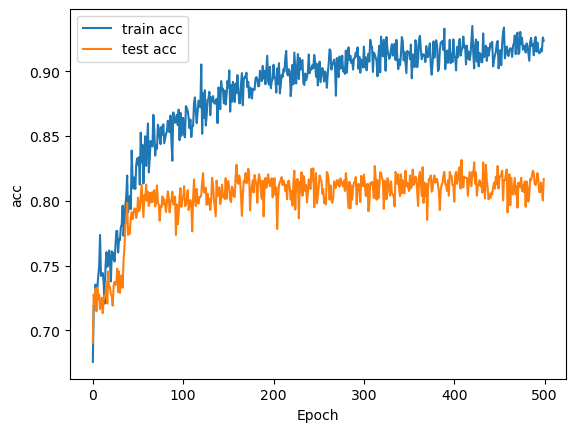

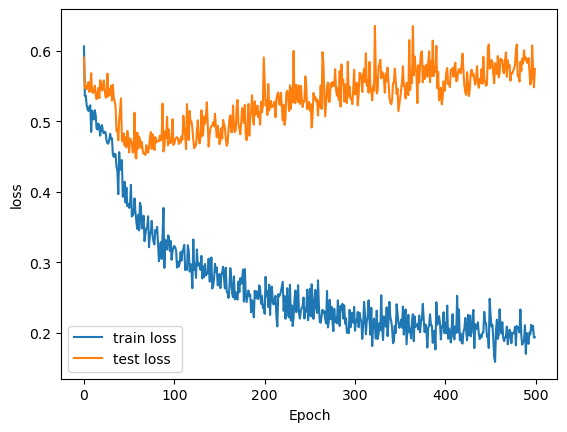

In [10]:
draw_acc_history(history)
draw_loss_history(history)

In [11]:
model_best = EEGNET().to(device)
model_best.load_state_dict(torch.load(f"./best.ckpt"))
model_best.eval()


with torch.no_grad():

    batch_test_acc = []
    batch_test_loss = []
    
    for batch in tqdm(test_loader):
        features, labels = batch
        labels = labels.to(device)
        test_pred = model_best(features.to(device))
        loss = criterion(test_pred, labels.long()) 
        acc = (test_pred.argmax(dim= -1)== labels).float().mean()
        batch_test_acc.append(acc)
        batch_test_loss.append(loss.item())

    test_acc = sum(batch_test_acc) / len(batch_test_acc)
    test_loss = sum(batch_test_loss) / len(batch_test_loss)

    print(f"[ Test ] loss = {test_loss:.5f}, acc = {test_acc:.5f}")
        


  0%|          | 0/34 [00:00<?, ?it/s]

100%|██████████| 34/34 [00:00<00:00, 538.17it/s]

[ Test ] loss = 0.57583, acc = 0.83150
